In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#TODO попробовать добавлять бинаризованную картинку в фичи
#TODO попробовать биноризавать текст лучше:добавить надутие, чтобы тест был более плотным

In [3]:
%config Completer.use_jedi = False

In [4]:
import os
import PIL
from PIL import Image, ImageFont, ImageDraw
import numpy as np
import tqdm
import pandas as pd
import sys
import cv2
import torch
from tqdm import tqdm_notebook as tn
import matplotlib.pyplot as plt

In [5]:
# diskPath = "/content/drive/MyDrive/"
# pathToDiplomaData = diskPath + "diplomaData/"
# pathToOutDir = diskPath + "diplomaData/binarizationGeneratedData"
# pathToOutDir = diskPath + "diplomaData/binarizationGeneratedData2"
# pathToGenerated = pathToOutDir + "/generated/"
# pathToGT = pathToOutDir + "/gt/"
# folderToDump = diskPath + "diplomaData/dumpsDetection"

In [6]:
diskPath = "D:/"
pathToDiplomaData = diskPath + "Data\Diploma/"
pathToOutDir = pathToDiplomaData + "generated/"
pathToTrain1 = pathToOutDir + "/Train1/"
pathToTrain2 = pathToOutDir + "/Train2/"
pathToTrain3 = pathToOutDir + "/Train3/"
pathToTest = pathToOutDir + "/Test/"
pathToValidation = pathToOutDir + "/Validate/"

pathToTrain1 = pathToOutDir + "/Train1_noAugModifiedFullBin/"
pathToTrain3 = pathToOutDir + "/Train3_noAugModifiedFullBin/"
pathToValidation = pathToOutDir + "/Validate_noAugModifiedFullBin/"
pathToTest = pathToOutDir + "/Test_noAugModifiedFullBin/"

pathToTrain1 = pathToOutDir + "/Train1_noAugModified/"
pathToTrain3 = pathToOutDir + "/Train3_noAugModified/"
pathToValidation = pathToOutDir + "/Validate_noAugModified/"
pathToTest = pathToOutDir + "/Test_noAugModified/"


pathToRealData = R"D:\Data\Diploma\real\dataset\\"

pathToGT = "gt/"
pathToGeneated = "generated/"
pathToDataList = "dataList.txt"

folderToDump = pathToDiplomaData + "dumps/"

In [7]:
os.makedirs(folderToDump, exist_ok=True)

In [8]:
device = "cuda"
#device = "cpu"

In [9]:
# !mkdir "binarizationGeneratedData2"
# !cp "/content/drive/MyDrive/diplomaData/zip/1.zip" "./binarizationGeneratedData2/1.zip"
# !cp "/content/drive/MyDrive/diplomaData/zip/2.zip" "./binarizationGeneratedData2/2.zip"
# !cp "/content/drive/MyDrive/diplomaData/zip/3.zip" "./binarizationGeneratedData2/3.zip"
# !cp "/content/drive/MyDrive/diplomaData/zip/4.zip" "./binarizationGeneratedData2/4.zip"
# !cp "/content/drive/MyDrive/diplomaData/zip/5.zip" "./binarizationGeneratedData2/5.zip"
# !cp "/content/drive/MyDrive/diplomaData/zip/6.zip" "./binarizationGeneratedData2/6.zip"
# !cp "/content/drive/MyDrive/diplomaData/zip/7.zip" "./binarizationGeneratedData2/7.zip"

# !mkdir "binarizationGeneratedData2/data"
# !unzip "./binarizationGeneratedData2/1.zip" -d "binarizationGeneratedData2/data"
# !unzip "./binarizationGeneratedData2/2.zip" -d "binarizationGeneratedData2/data"
# !rm  "binarizationGeneratedData2/1.zip"
# !rm "binarizationGeneratedData2/2.zip"
# !unzip "./binarizationGeneratedData2/3.zip" -d "binarizationGeneratedData2/data"
# !unzip "./binarizationGeneratedData2/4.zip" -d "binarizationGeneratedData2/data"

# !rm  "binarizationGeneratedData2/3.zip"
# !rm "binarizationGeneratedData2/4.zip"

# !unzip "./binarizationGeneratedData2/5.zip" -d "binarizationGeneratedData2/data"
# !unzip "./binarizationGeneratedData2/6.zip" -d "binarizationGeneratedData2/data"
# !unzip "./binarizationGeneratedData2/7.zip" -d "binarizationGeneratedData2/data"
# !rm  "binarizationGeneratedData2/5.zip"
# !rm "binarizationGeneratedData2/6.zip"
# !rm  "binarizationGeneratedData2/7.zip"


In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
# pathToOutDir = "./binarizationGeneratedData2/data/binarizationGeneratedData2"
# pathToGenerated = pathToOutDir + "/generated/"
# pathToGT = pathToOutDir + "/gt/"
# folderToDump = diskPath + "diplomaData/dumpsDetection"

In [12]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision

In [13]:
import json

In [14]:
imageSize = 800

In [15]:
class ResizeMinSide(object):
    def __init__(self, minSize=512, maxScaleFactor = 32):
        self.minSize = minSize
        self.maxScaleFactor = maxScaleFactor  #во скок раз сжимается картинка

    def __call__(self, img):
        w0,h0 = img.size
        w,h = img.size
        if h < w:
          h, w = self.minSize, w // h * self.minSize
          w = (w // 32 + 1) * 32
        else:
          h, w = h // w * self.minSize, self.minSize
          h = (h // 32 + 1) * 32
        h = int(h)
        w = int(w)
        h,w = (imageSize, imageSize)

        img = img.resize((w,h), PIL.Image.BILINEAR)
        newImg = Image.new(img.mode, (imageSize, imageSize), (255,255,255))
        newImg.paste(img, (0,0))

        assert(newImg.size == (imageSize,imageSize))
        ratio = (w/w0, h/h0)
        return newImg, ratio

    def __repr__(self):
        return "resizeMinSide"

class BinaryImageToTensor(object):
    def __init__(self):
      pass

    def __call__(self, img):
        return torch.from_numpy(np.array(img, dtype=np.long))

    def __repr__(self):
        return "binaryImageToTensor"

In [16]:
def getOuterRect(polygon, ratio=(1,1)):
  xMax, yMax,xMin, yMin = *polygon[0],*polygon[0]
  for point in polygon:
    x,y = point
    xMax, xMin, yMax, yMin = max(x, xMax), min(x,xMin), max(y,yMax), min(y, yMin)
  return(xMin*ratio[0], yMin*ratio[1], xMax*ratio[0], yMax*ratio[1])

In [17]:
allCharacters = {'\t': 95, '\n': 96, '\x0b': 98, '\x0c': 99, '\r': 97, ' ': 94, '!': 62, '"': 63, '#': 64, '$': 65, '%': 66, '&': 67, "'": 68, '(': 69, ')': 70, '*': 71, '+': 72, ',': 73, '-': 74, '.': 75, '/': 76, '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, ':': 77, ';': 78, '<': 79, '=': 80, '>': 81, '?': 82, '@': 83, 'A': 36, 'B': 37, 'C': 38, 'D': 39, 'E': 40, 'F': 41, 'G': 42, 'H': 43, 'I': 44, 'J': 45, 'K': 46, 'L': 47, 'M': 48, 'N': 49, 'O': 50, 'P': 51, 'Q': 52, 'R': 53, 'S': 54, 'T': 55, 'U': 56, 'V': 57, 'W': 58, 'X': 59, 'Y': 60, 'Z': 61, '[': 84, '\\': 85, ']': 86, '^': 87, '_': 88, '`': 89, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'q': 26, 'r': 27, 's': 28, 't': 29, 'u': 30, 'v': 31, 'w': 32, 'x': 33, 'y': 34, 'z': 35, '{': 90, '|': 91, '}': 92, '~': 93}

In [18]:
from PIL import ImageOps

In [19]:
def _binarize(image):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    (T, threshInv) = cv2.threshold(blurred, 0, 255, cv2.THRESH_OTSU)
    return threshInv

def binarize(image):
    image = np.array(image)
    first = np.array([image[:,:,0], image[:,:,0], image[:,:,0]]).transpose(1, 2,0)
    second = np.array([image[:,:,1], image[:,:,1], image[:,:,1]]).transpose(1, 2,0)
    third = np.array([image[:,:,2], image[:,:,2], image[:,:,2]]).transpose(1, 2,0)
    threshInv = _binarize(image)
    threshInv1 = _binarize(first)
    threshInv2 = _binarize(second)
    threshInv3 = _binarize(third)

    binarized = np.array([threshInv, threshInv1, threshInv2, threshInv3])
    return binarized

In [20]:
class BinarizationDataset(Dataset):
    def __init__(self, metadataFilePath, dataPath, transform=None, transfGt=None):
      """
      """
      self.dataPath = dataPath
      self.transform = transform
      self.transfGt = transfGt
      self.ratios = dict()
      self.gtDataAnatation = dict()
      with open(metadataFilePath, "r") as f:
        self.metadata = json.load(f)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        #idx = 0
        #print(self.metadata[idx])
        distortedImage = PIL.Image.open(os.path.join(self.dataPath, self.metadata[idx]["distortedImage"]))
        distortedImage, ratio = ResizeMinSide()(distortedImage)
        gtImage = PIL.Image.open(os.path.join(self.dataPath, self.metadata[idx]["gtImage"]))
        gtImage = gtImage.convert('RGB')
#         gtImage = gtImage.convert('RGBA')
        gtImage, ratio = ResizeMinSide()(gtImage)
        characterMap = PIL.Image.open(os.path.join(self.dataPath, self.metadata[idx]["characterMap"]))
        characterMap = characterMap.convert('RGB')
        characterMap, ratio = ResizeMinSide()(characterMap)

        self.ratios[idx] = ratio
        
        gtImage = gtImage.convert('1')
        characterMap = ImageOps.grayscale(characterMap)
       # print(characterMap.mod)
        distortedImage = distortedImage.convert('RGB')
        binarized = binarize(distortedImage)


        if self.transfGt:
            gtImage = self.transfGt(gtImage)
            gtImage = 1 - gtImage
            characterMap = self.transfGt(characterMap)
        if self.transform:
            distortedImage = self.transform(distortedImage)
            
       # characterMap = (255 - characterMap) / 255
        characterMap = characterMap / 255
       # characterMap = characterMap * (characterMap > 0.1).float()
        #annotation = ""
        # gtData = dict()
        # boxes = []
        # labels = []
        # with open( os.path.join(self.dataPath, self.metadata[idx]["annotation"])) as f:
        #   annotation = json.load(f)
        # ratio = self.ratios[idx]
        # boxes.extend([getOuterRect(polygon, ratio) for polygon in annotation["wordRects"]])
        # labels.extend([1 for polygon in annotation["wordRects"]])
        
        # # for i in range(len(annotation["wordsCharactersRects"])):
        # #   boxes.extend([getOuterRect(polygon, ratio) for polygon in annotation["wordsCharactersRects"][i]])
        # #   #labels.extend([1 for character in annotation["words"][i]])
        # #   labels.extend([allCharacters[character] + 1 for character in annotation["words"][i]])
        # gtData["boxes"] = torch.from_numpy(np.array(boxes, dtype=np.float)).cuda()
        # gtData["labels"] = torch.from_numpy(np.array(labels, dtype=np.int)).cuda()

        # self.gtDataAnatation[idx] = gtData
        #возвращаем подготовленную картинку и название ее файла
        return distortedImage, gtImage, characterMap, binarized, idx

    def getAnnotation(self, idx):
        annotation = ""
        with open( os.path.join(self.dataPath, self.metadata[idx]["annotation"])) as f:
          annotation = json.load(f)
        return annotation
    def getOriginalDistortedImage(self, idx):
      distortedImage = PIL.Image.open(os.path.join(self.dataPath, self.metadata[idx]["distortedImage"]))
      distortedImage,_ = ResizeMinSide()(distortedImage)
      return distortedImage

    def getBboxesAndSymbolclasses(self, indices):
      data = []
      boxes = []
      for i in indices:
        idx = i.item()
        annotation = ""
        gtData = dict()
        #boxes = []
        #labels = []
        with open( os.path.join(self.dataPath, self.metadata[idx]["annotation"])) as f:
          annotation = json.load(f)
        ratio = self.ratios[idx]
        boxes.append([getOuterRect(polygon, ratio) for polygon in annotation["wordRects"]])
        #labels.extend([1 for polygon in annotation["wordRects"]])
        
        # for i in range(len(annotation["wordsCharactersRects"])):
        #   boxes.extend([getOuterRect(polygon, ratio) for polygon in annotation["wordsCharactersRects"][i]])
        #   #labels.extend([1 for character in annotation["words"][i]])
        #   labels.extend([allCharacters[character] + 1 for character in annotation["words"][i]])
        #gtData["boxes"] = torch.from_numpy(np.array(boxes, dtype=np.float)).to(device)
       # gtData["labels"] = torch.from_numpy(np.array(labels, dtype=np.int)).to(device)
        #data.append(gtData)
      return boxes#data

In [21]:
# datasetTrain1 = BinarizationDataset(pathToTrain1 + pathToDataList, pathToTrain3)
# datasetValidation = BinarizationDataset(pathToValidation + pathToDataList, pathToTrain1)

In [22]:
pathToTrain1 + pathToDataList

'D:/Data\\Diploma/generated//Train1_noAugModified/dataList.txt'

In [23]:
def getAnnotationImage(image, annotation):
    img = image.copy()
    ind = 0
    for rotated, characters in zip(annotation["wordRects"], annotation["wordsCharactersRects"]):
        d = ImageDraw.Draw(img)
        ind = ind + 1
        d.line((rotated[0][0], rotated[0][1], rotated[1][0], rotated[1][1]), fill=(255,0,255), width=2)
        d.line((rotated[1][0], rotated[1][1], rotated[2][0], rotated[2][1]), fill=(255,0,255), width=2)
        d.line((rotated[2][0], rotated[2][1], rotated[3][0], rotated[3][1]), fill=(255,0,255), width=2)
        d.line((rotated[3][0], rotated[3][1], rotated[0][0], rotated[0][1]), fill=(255,0,255), width=2)

        for c in characters:
            d.line((c[0][0], c[0][1], c[1][0], c[1][1]), fill=(255,0,255), width=2)
            d.line((c[1][0], c[1][1], c[2][0], c[2][1]), fill=(255,0,255), width=2)
            d.line((c[2][0], c[2][1], c[3][0], c[3][1]), fill=(255,0,255), width=2)
            d.line((c[3][0], c[3][1], c[0][0], c[0][1]), fill=(255,0,255), width=2)
    return img

In [24]:
# distortedImage, _, ind = dataset.__getitem__(0)
# annotation = dataset.getAnnotation(0)
# getAnnotationImage(distortedImage, annotation)

In [25]:
from torch import nn
import torch
import torch.nn.functional as F

In [26]:
# from torchsummary import summary
#backBone = torchvision.models.mobilenet_v3_large(True, True) 
#summary(nn.Sequential(*list(backBone.features)[:17]), (3, 1024, 758))

In [27]:
import random
import numpy as np
import torch.backends.cudnn as cudnn

def set_random_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    random.seed(seed)
    np.random.seed(seed)
    
def prepare_cudnn(deterministic=True, benchmark=False):
    if torch.cuda.is_available():
        # CuDNN reproducibility
        # https://pytorch.org/docs/stable/notes/randomness.html#cudnn
        cudnn.deterministic = deterministic

        # https://discuss.pytorch.org/t/how-should-i-disable-using-cudnn-in-my-code/38053/4
        cudnn.benchmark = benchmark
        
def set_deterministic_behaviour(seed=42):
    set_random_seed(seed)
    prepare_cudnn(deterministic=True, benchmark=False)

In [28]:
# сделаем предобработку изображения, которая была применена при обучении
import torchvision
set_deterministic_behaviour

transf = torchvision.transforms.Compose([
                                #ResizeMinSide(),
                                torchvision.transforms.PILToTensor(),
                                transforms.ConvertImageDtype(torch.float),
                                #transforms.Normalize(mean=[0.485], std=[0.229]) 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                             
                                ])
transfGt = torchvision.transforms.Compose([
                                #ResizeMinSide(),
                                BinaryImageToTensor()
                                ])
#собственно сам загрузчик
train_dataset1 = BinarizationDataset(pathToTrain1 + pathToDataList, pathToTrain1, transf, transfGt)
#train_dataset2 = BinarizationDataset(pathToTrain3 + pathToDataList, pathToTrain3, transf, transfGt)
# train_dataset3 = BinarizationDataset(pathToTrain3 + pathToDataList, pathToTrain3, transf, transfGt)
valid_dataset = BinarizationDataset(pathToValidation + pathToDataList, pathToValidation, transf, transfGt)
test_dataset = BinarizationDataset(pathToTest + pathToDataList, pathToTest, transf, transfGt)

#real_dataset = BinarizationDataset(pathToRealData + pathToDataList, pathToRealData, transf, transfGt)

train_dataLoader1 = torch.utils.data.DataLoader(train_dataset1,
                                          batch_size=4,
                                          shuffle=False,
                                          num_workers=0)

# real_dataLoader = torch.utils.data.DataLoader(real_dataset,
#                                           batch_size=4,
#                                           shuffle=True,
#                                           num_workers=0)

# train_dataLoader3 = torch.utils.data.DataLoader(train_dataset3,
#                                           batch_size=4,
#                                           shuffle=True,
#                                           num_workers=0)
valid_dataLoader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=0)

test_daraLoader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=0)

                                

In [29]:
for a, b, c, d, e in tn(train_dataLoader1):
    #pass
    break

<ipython-input-29-19ac42710ee8>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for a, b, c, d, e in tn(train_dataLoader1):


<ipython-input-15-5733ceb21e19>:35: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return torch.from_numpy(np.array(img, dtype=np.long))


In [30]:
train_dataset1.getBboxesAndSymbolclasses(e)

[[(303.3470565535864,
   5.829483809292979,
   504.26501547117425,
   114.09805883445516),
  (144.08602150537635,
   687.2062663185379,
   344.80286738351253,
   725.8485639686685),
  (168.93061699285764,
   161.80875141351552,
   421.49418751235225,
   214.2888802308292),
  (98.9247311827957, 24.02088772845953, 187.09677419354838, 49.08616187989556),
  (643.4892693077129,
   95.33942290646847,
   702.5044527304333,
   137.97844038208473),
  (627.9569892473119, 758.2245430809401, 694.6236559139785, 783.2898172323761),
  (5.734767025089606,
   254.83028720626635,
   174.91039426523298,
   303.9164490861619),
  (525.4480286738351,
   491.90600522193216,
   681.0035842293906,
   537.8590078328982),
  (517.8901975264934,
   300.6719970608579,
   691.4842970215149,
   374.17160981135424),
  (482.20263098890683, 573.861563617197, 689.5298585047402, 620.9122738525184),
  (22.22222222222222,
   427.15404699738906,
   154.83870967741936,
   454.3080939947781),
  (518.9964157706094, 760.31331592

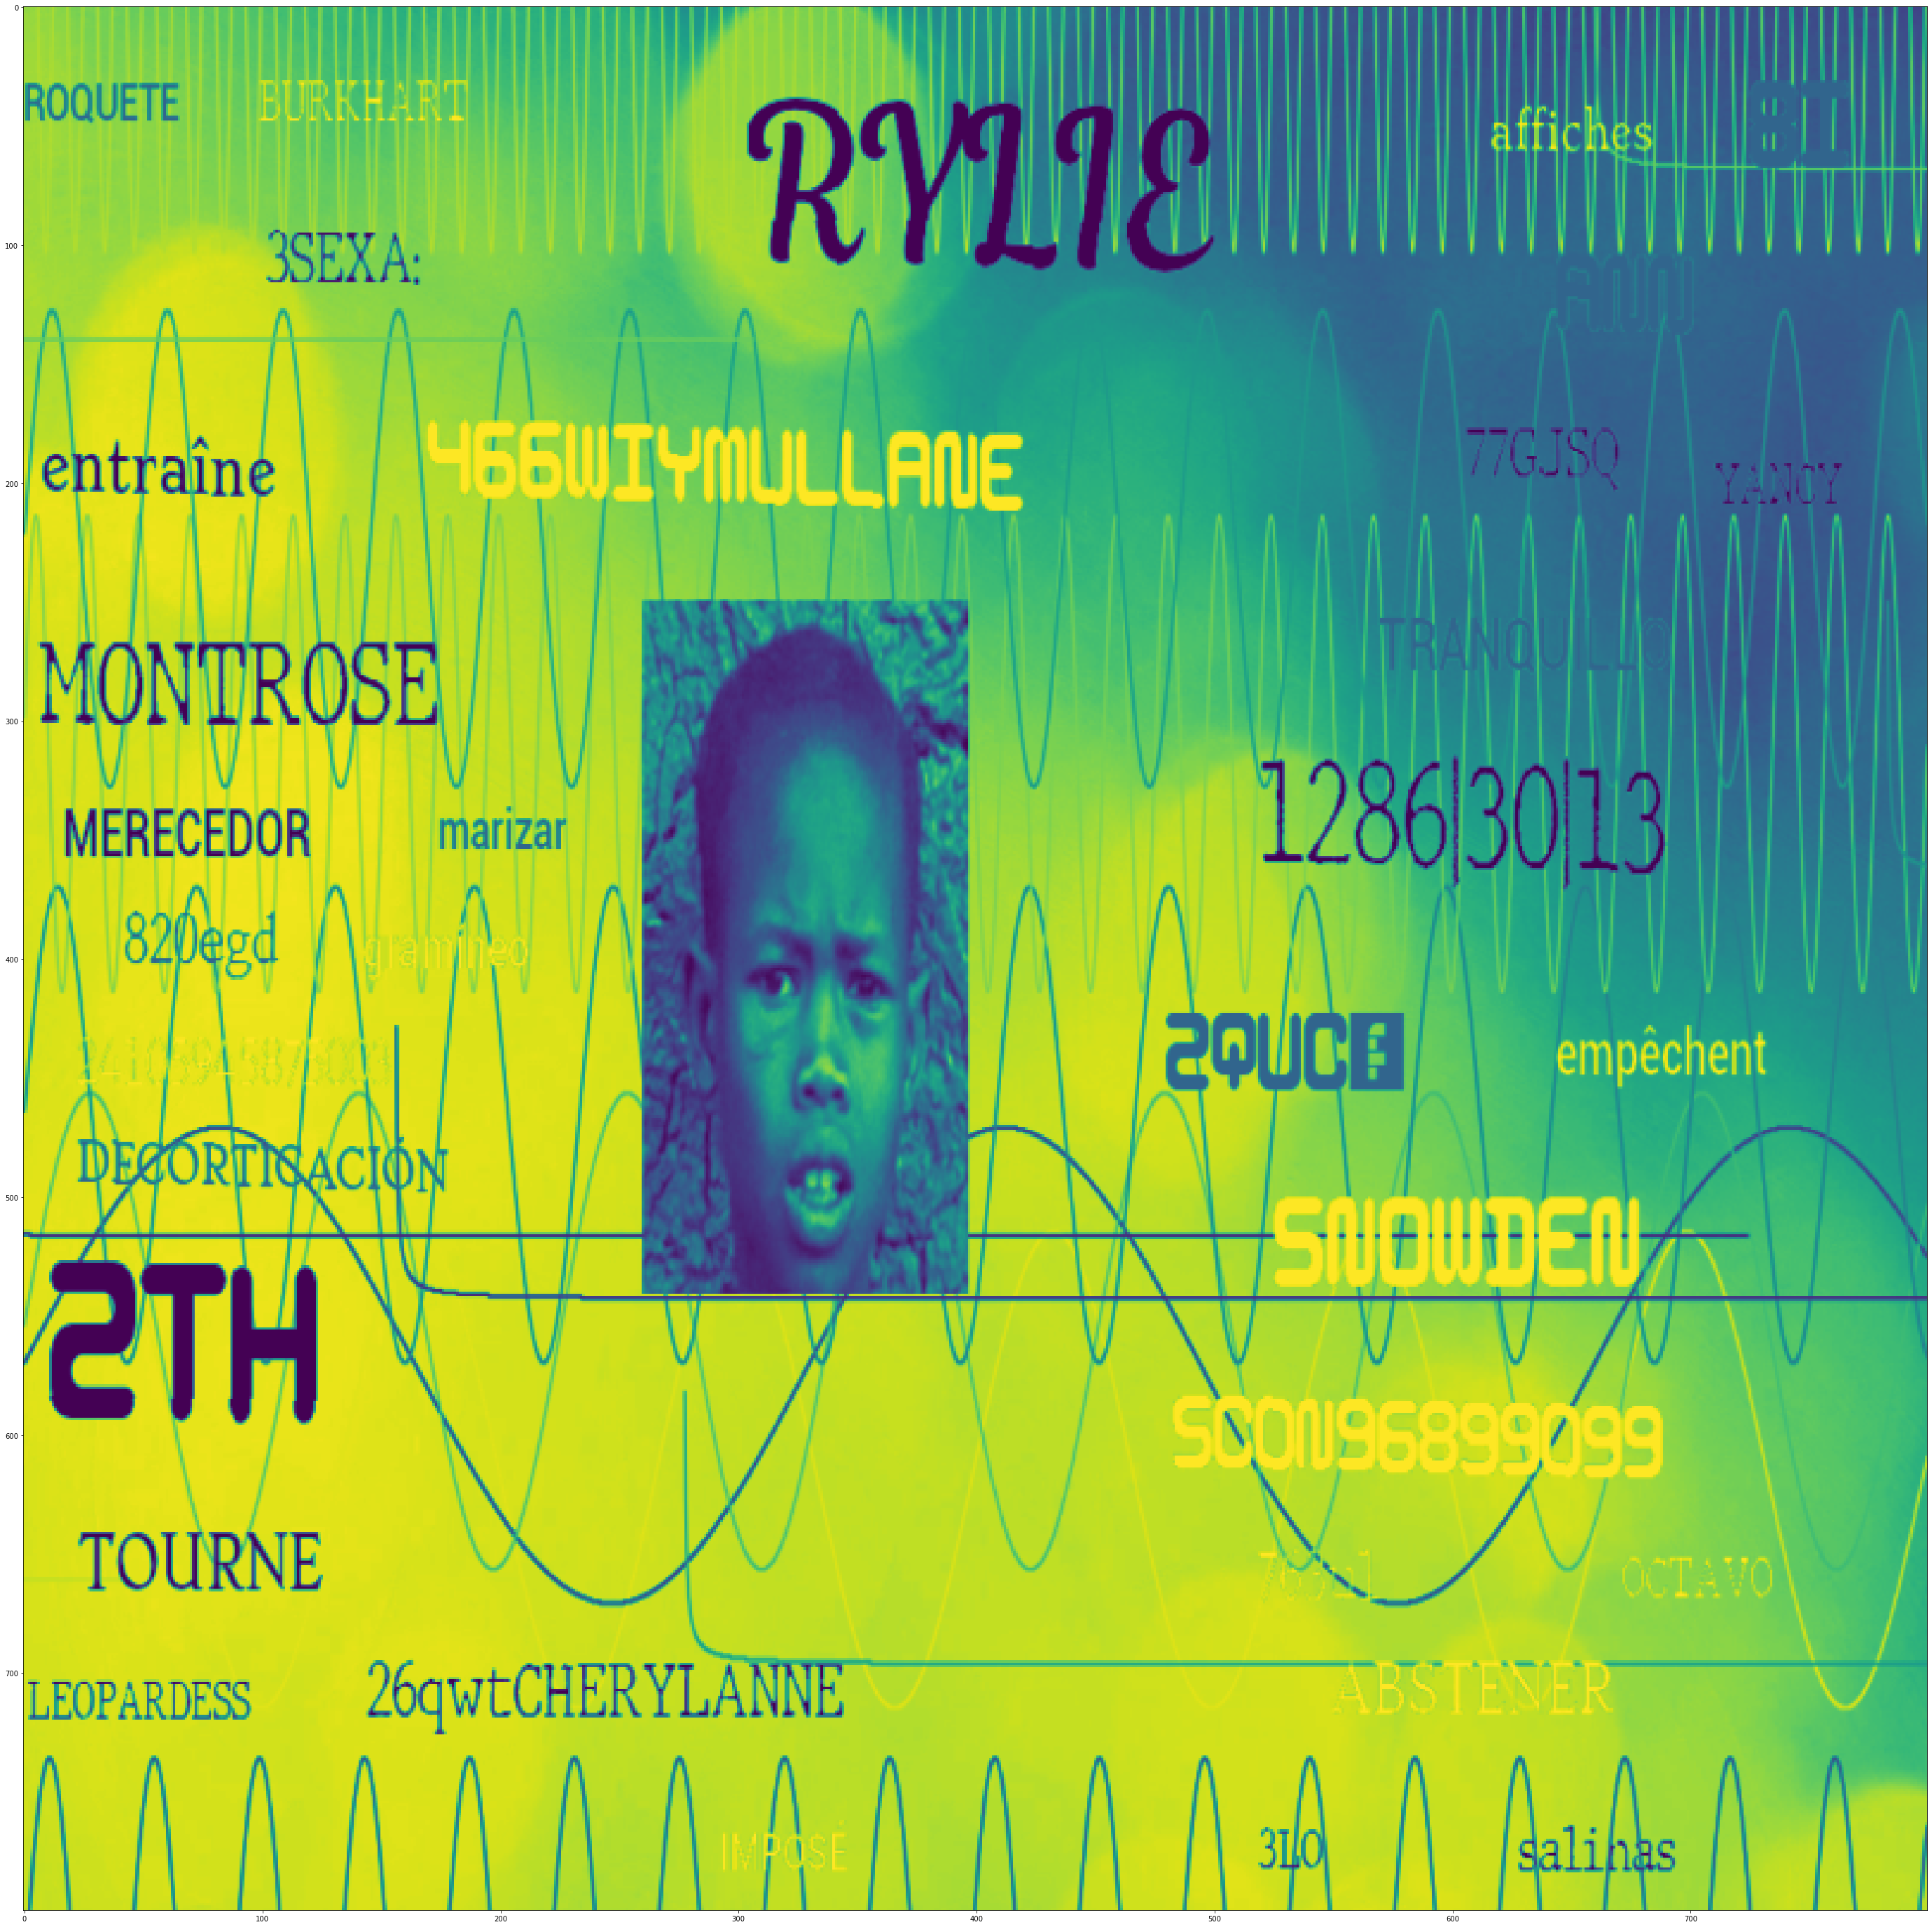

In [31]:
s = 50
plt.figure(figsize=(s,s))
plt.imshow(a[0][0])
#plt.imshow(a[0].numpy().transpose(1,2,0))

In [32]:
#c

In [33]:
c.min()

tensor(0.)

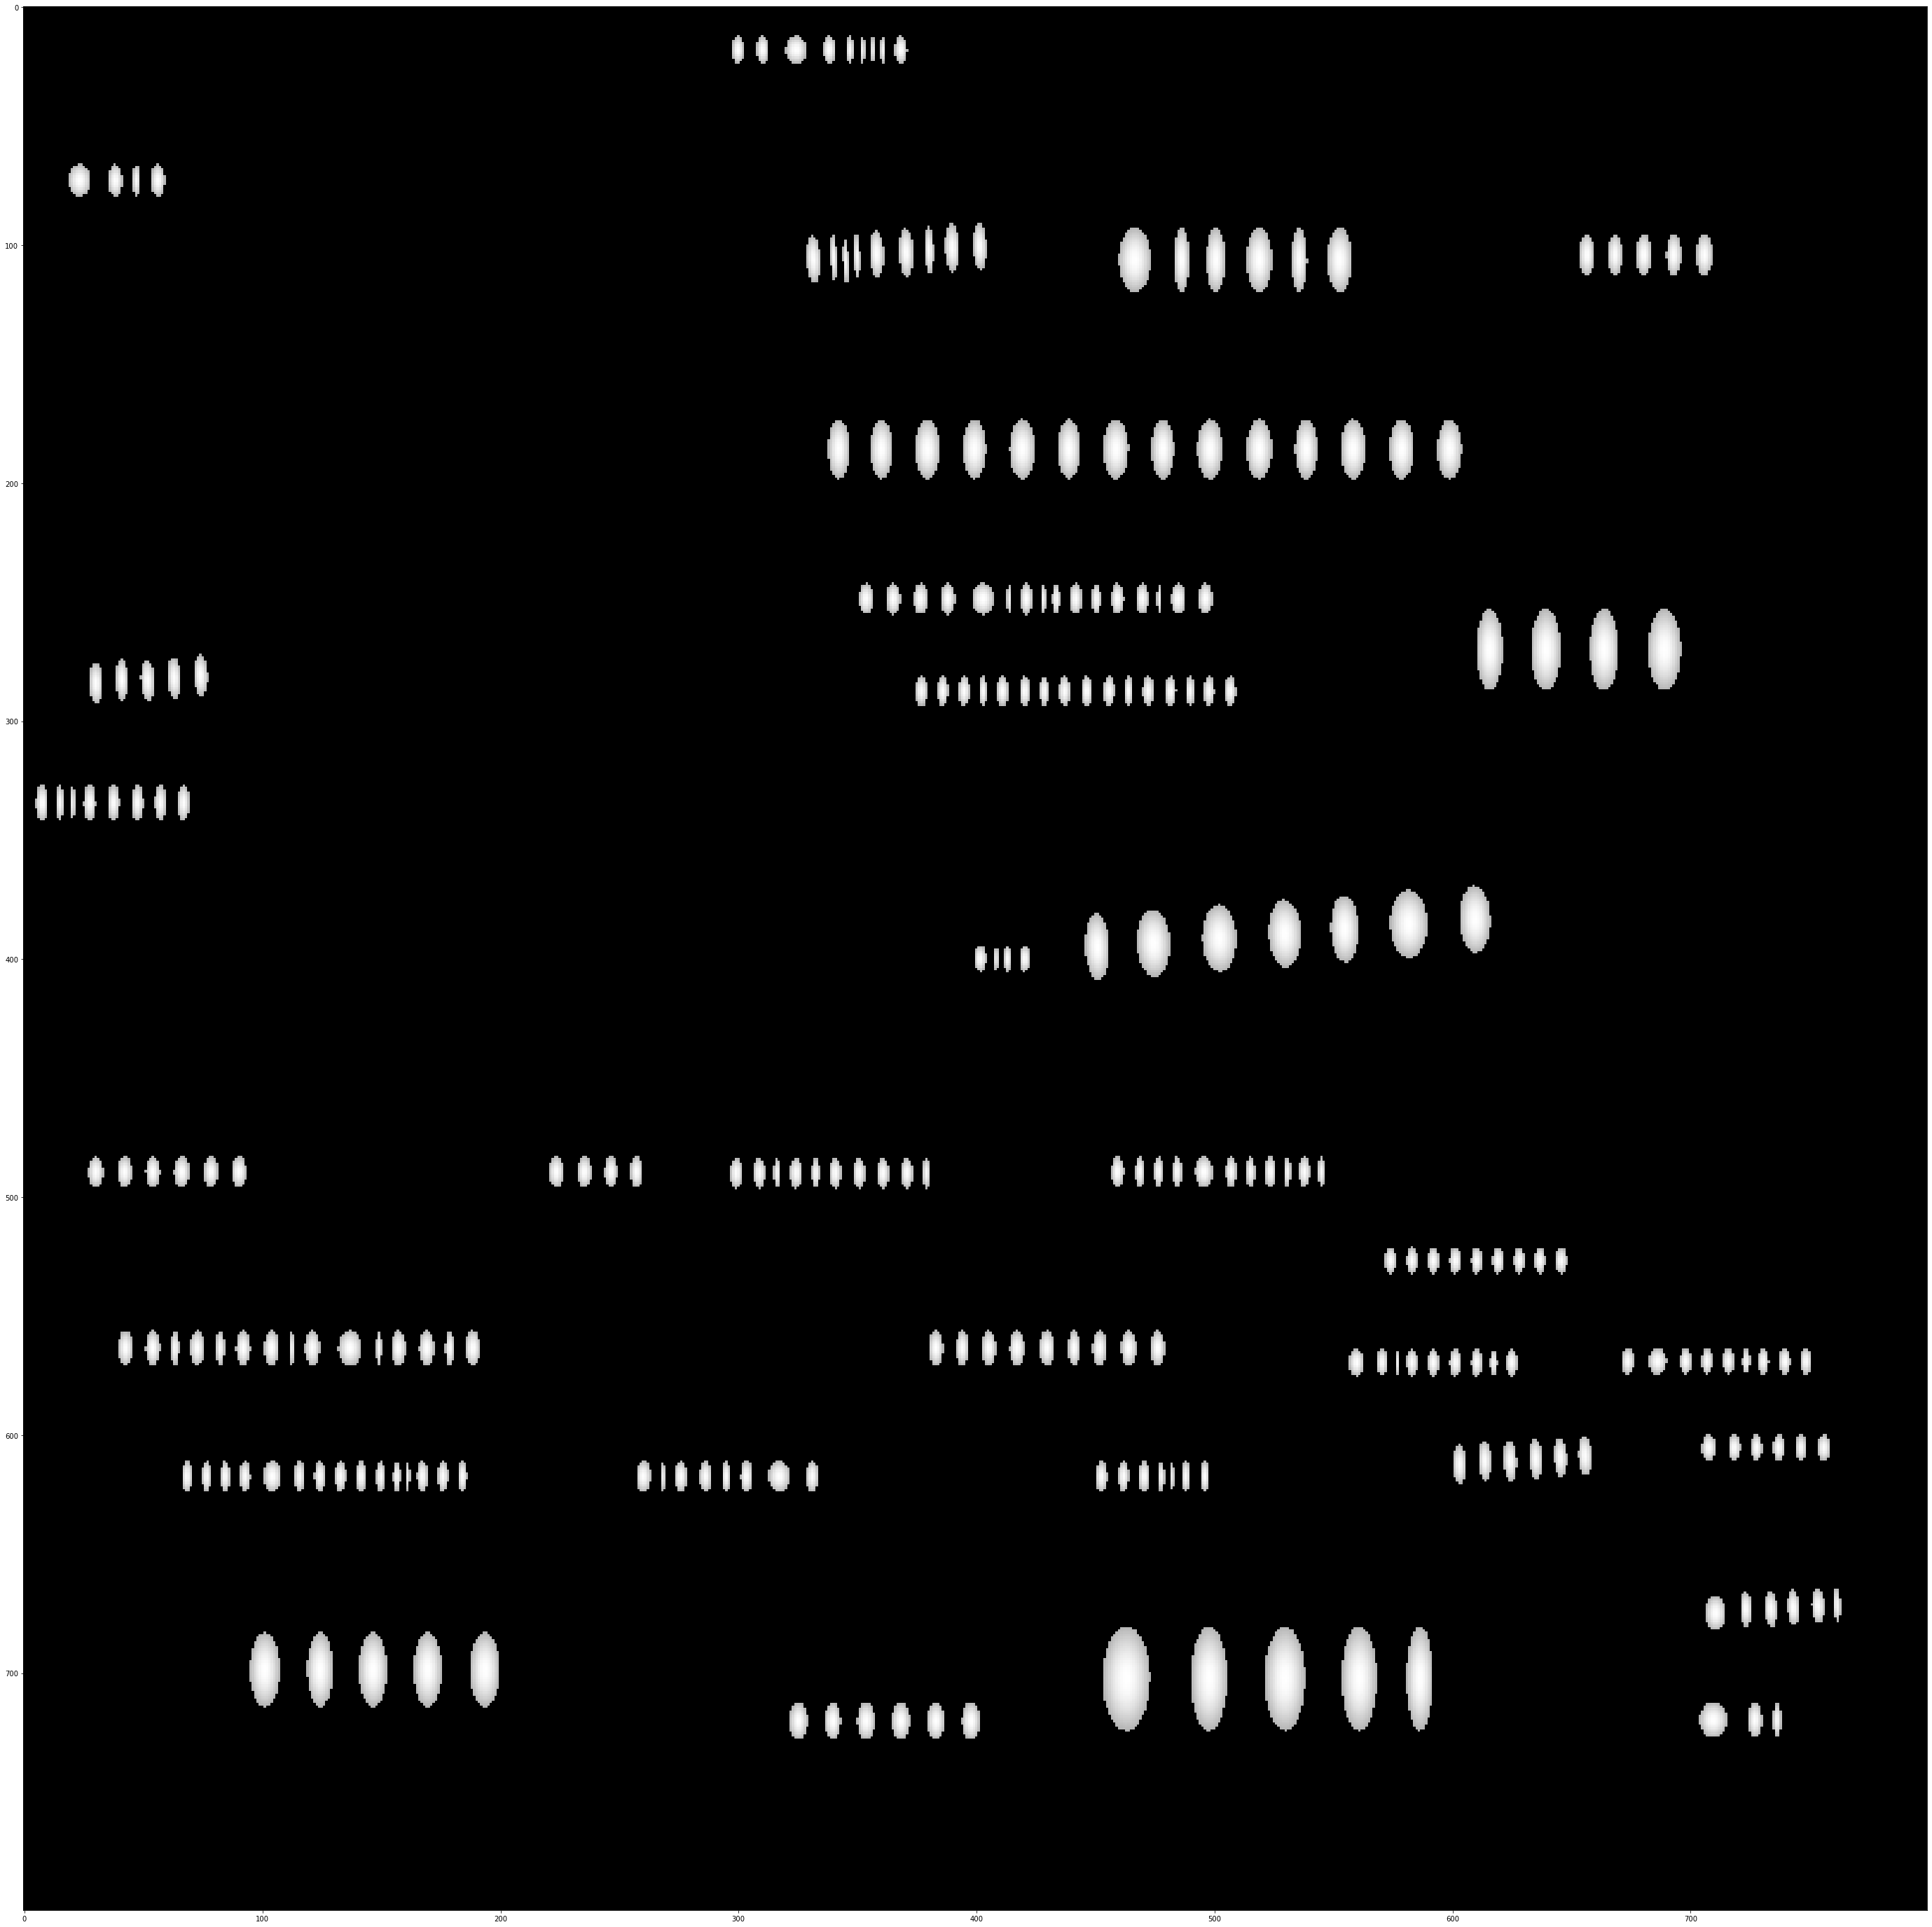

In [34]:
t = c * (c>0.7).float()
t = t * (t>0.7).float()
t = t * (t>0.7).float()
t = t * (t>0.7).float()

s = 50
plt.figure(figsize=(s,s))
plt.imshow(t[3].detach().cpu().squeeze().numpy()*255, cmap="gray")

In [35]:
class Upsample2(nn.Module):
  def __init__(self, numFeatures):
    super(Upsample2, self).__init__()
    self.upsample = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='bilinear'),
        nn.BatchNorm2d(numFeatures),
        nn.Conv2d(numFeatures, numFeatures // 2, kernel_size=3, padding=1)
        #nn.Conv2d(numFeatures, numFeatures // 2, kernel_size=1, padding=0)
    )
  
  def forward(self, x):
    return self.upsample(x)

In [36]:
from torchsummary import summary

In [37]:
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
from tqdm import tqdm_notebook as tn
import json
from torch.autograd import Variable

In [38]:
def diceCoeffv2(pred, gt, eps=1e-5, activation='sigmoid'):
    r""" computational formula：
        dice = (2 * tp) / (2 * tp + fp + fn)
    """
 
    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = nn.Softmax2d()
    else:
        assert(false)
 
    pred = activation_fn(pred)
 
    N = gt.size(0)
    pred_flat = pred.view(N, -1)
    gt_flat = gt.view(N, -1)
 
    tp = torch.sum(gt_flat * pred_flat, dim=1)
    fp = torch.sum(pred_flat, dim=1) - tp
    fn = torch.sum(gt_flat, dim=1) - tp
    loss = (2 * tp + eps) / (2 * tp + fp + fn + eps)

    return loss.sum() / N

class DiceLoss(nn.Module):
    __name__ = 'dice_loss'
 
    def __init__(self, activation='sigmoid'):
        super(DiceLoss, self).__init__()
        self.activation = activation
 
    def forward(self, y_pr, y_gt):
        return 1 - diceCoeffv2(y_pr, y_gt, activation=self.activation)


class FocalLoss(nn.Module):
    def __init__(self, gamma=1, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [39]:
class FocalLossByWords(nn.Module):
    def __init__(self, gamma=1, size_average=True):
        super(FocalLossByWords, self).__init__()
        self.gamma = gamma
        self.size_average = size_average
        
    def getOneImageMask(self, topClass, target, wordsRects):
        #H,W,C
        mask = torch.zeros_like(topClass, dtype=torch.float)
        backgroundMask = torch.ones_like(topClass, dtype=torch.float)
        
        chosen = [0]# np.random.choice(np.arange(0, len(wordsRects)), size=1, replace=False)
        for i in chosen:
            wordRect = wordsRects[i]
            left, bottom, right, top   = wordRect
            right, left, top, bottom = int(right), int(left), int(top), int(bottom)
            topClassClass = topClass[bottom:top, left:right]
            targetClass = target[bottom:top,left:right]
            iou = torch.sum(topClassClass * targetClass) / (torch.sum(topClassClass) + torch.sum(targetClass) + eps)
            assert(iou <= 1)
            mask[bottom:top][left:right] = 1
        return mask.type(torch.int64)

    def forward(self, input, target, topClass, wordsRects):
        assert(torch.min(target) == 0)
        assert(input.shape[0] == target.shape[0] and topClass.shape[0] == target.shape[0] and topClass.shape[0] == len(wordsRects))
        mask = [self.getOneImageMask(topClass[i].squeeze(0), target[i].detach(), wordsRects[i]).unsqueeze(0) for i in range(input.shape[0])]
        mask = torch.cat(mask, dim=0)
        assert(mask.shape == target.shape)
        target = target * mask
        mask = torch.cat([mask.unsqueeze(1),mask.unsqueeze(1)], dim=1)# N,C,H,W
        #print(mask)
        input = input * mask
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
      
        target = target.view(-1,1)


        logpt = F.log_softmax(input)

        assert(torch.min(target) == 0)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [40]:
eps=1e-5
class Maploss(nn.Module):
    def __init__(self, use_gpu = True, minThreshold = 0.1):

        super(Maploss,self).__init__()
        self.minThreshold = minThreshold

    def single_image_loss(self, pre_loss, loss_label):
        batch_size = pre_loss.shape[0]
        # sum_loss = torch.mean(pre_loss.view(-1))*0
        # pre_loss = pre_loss.view(batch_size, -1)
        # loss_label = loss_label.view(batch_size, -1)
        

        positive_pixel = (loss_label > 0.1).float()
        positive_pixel_number = torch.sum(positive_pixel) + eps
        positive_loss_region = pre_loss * positive_pixel

        positive_loss = torch.sum(positive_loss_region) / positive_pixel_number

        negative_pixel = (loss_label <= 0.1).float()
        negative_pixel_number = torch.sum(negative_pixel) + eps

        if negative_pixel_number < 3*positive_pixel_number:
            negative_loss_region = pre_loss * negative_pixel
            negative_loss = torch.sum(negative_loss_region) / negative_pixel_number
            
        else:
            negative_loss_region = pre_loss * negative_pixel
            negative_loss = torch.sum(torch.topk(negative_loss_region.view(-1), int(3*positive_pixel_number))[0]) / (positive_pixel_number*3)
#             print(negative_pixel_number)
#             print(positive_pixel_number)
        # negative_loss_region = pre_loss * negative_pixel
        # negative_loss = torch.sum(negative_loss_region) / negative_pixel_number


        total_loss = positive_loss + negative_loss
        return total_loss

    def forward(self, region_scores_pre, region_scores_label):#, mask):
        assert((region_scores_label>0.1).sum()>0)
        loss_fn = torch.nn.MSELoss(reduce=False, size_average=False)
        #print(region_scores_pre.size())
        #print(region_scores_label.size())
        assert region_scores_label.size() == region_scores_pre.size()
      #  print(self.minThreshold)
      #  print(region_scores_label)
        region_scores_label = region_scores_label * (region_scores_label > self.minThreshold).int()
        assert((region_scores_label>0.1).sum()>0)
        loss1 = loss_fn(region_scores_pre, region_scores_label)
        loss_region = loss1#torch.mul(loss1, mask)

        char_loss = self.single_image_loss(loss_region, region_scores_label)
        return char_loss

In [41]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

def generateFastRCNNModel(backbone):
  backbone.out_channels = 960

  # let's make the RPN generate 5 x 3 anchors per spatial
  # location, with 5 different sizes and 3 different aspect
  # ratios. We have a Tuple[Tuple[int]] because each feature
  # map could potentially have different sizes and
  # aspect ratios
  anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                    aspect_ratios=((0.5, 1.0, 2.0),))

  # let's define what are the feature maps that we will
  # use to perform the region of interest cropping, as well as
  # the size of the crop after rescaling.
  # if your backbone returns a Tensor, featmap_names is expected to
  # be [0]. More generally, the backbone should return an
  # OrderedDict[Tensor], and in featmap_names you can choose which
  # feature maps to use.
  roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                  output_size=7,
                                                  sampling_ratio=2)

  # put the pieces together inside a FasterRCNN model
  model = FasterRCNN(backbone,
                    #num_classes=1#len(allCharacters) + 1, #2,#len(allCharacters), #0 for background
                    num_classes= 2,#len(allCharacters), #0 for background
                    rpn_anchor_generator=anchor_generator,
                    box_roi_pool=roi_pooler)
  
  return model

In [42]:
def plotImageBboxes(img, bboxes):
    bboxes = bboxes.detach().cpu().numpy()
    img = img.copy()
    ind = 0
    for bbox in bboxes:
        d = ImageDraw.Draw(img)
        d.rectangle([(bbox[0],bbox[1]),(bbox[2],bbox[3])], outline ="green")
    return img

In [43]:
# syntheticDataset.__getitem__(0)
# bb = syntheticDataset.getBboxesAndSymbolclasses(torch.from_numpy( np.array([0])))[0]
# plotImageBboxes(syntheticDataset.getOriginalDistortedImage(0), bb["boxes"])

In [44]:
SMOOTH = 1e-6
def countIOU(mask1, mask2):
    intersection = (mask1 * mask2).sum()
    union = mask1.sum() + mask2.sum()
    return intersection / (union + SMOOTH)

In [45]:
def processBatch(dataloader, net, lossFuncs, shouldPrint, shouldTrain,  optimizer= None, coefs = {"Dice":1, "CE":0.5}, trainDataset=None):
    print("shouldTrain " + str(shouldTrain) + " shouldPrint " + str(shouldPrint))
    train_loss = []
    ious = []
    progress = tn(dataloader)
    for i, data in enumerate(progress):
#       if i < 23:
#             continue
      distortedImage, gtImage, charMapGt, binImages, inds = data
      distortedImage = distortedImage.to(device)
      binImages = binImages.to(device)
      gtImage = gtImage.to(device)
      charMapGt = charMapGt.to(device)
      #print(charMapGt)
      
      if shouldTrain:
        optimizer.zero_grad()
        out = net((distortedImage, binImages))
      else:
        with torch.no_grad():
            out = net((distortedImage, binImages))
    
      loss = 0
      for k,v in out["train"].items():
        #print(v.shape)http://localhost:8888/notebooks/Data/Diploma/binarization/binarizationTraining.ipynb#
        v = torch.nan_to_num(v)
       # print(torch.max(v).item())
       # assert(torch.max(gtImage).item() <= 1)
       # assert(torch.max(v).item() <= 1)
#         print(k)
#         print(v.shape)
#         print(gtImage.shape)
       # print(gtImage.float().shape)
        if k in ["CE", "Dice", "CE0", "Dice0", "WordFL"]:
            gt = gtImage.long()
        elif k == "charMap":
            gt = charMapGt.float()
        else:
            gt = gtImage.float()
            
        if k not in coefs or k not in coefs or coefs[k]==0:
            continue
        if k == "WordFL":
            loss1 = lossFuncs[k](v, gt, out["topClass"].detach(), trainDataset.getBboxesAndSymbolclasses(inds)) * coefs[k]
        else:
            loss1 = lossFuncs[k](v, gt) * coefs[k]
       # print(loss1)
       # print(loss1.item())
        loss += loss1
        
#         plt.figure(figsize=(s,s))
#         plt.imshow(gt[0].detach().cpu().squeeze().numpy(), cmap="binary")
#         plt.show()
#         plt.figure(figsize=(s,s))
#         plt.imshow(v[0].detach().cpu().squeeze().numpy(), cmap="binary")
#         plt.show()

      if shouldPrint and i % 10 == 0:
        s = 10
#         plt.figure(figsize=(s,s))
#         plt.imshow(out["train"]["finalMap"][0].detach().cpu().squeeze().numpy(), cmap="binary")
#         plt.show()
        plt.figure(figsize=(s,s))
        plt.imshow(out["topClass"][0].detach().cpu().squeeze().numpy(), cmap="gray")
        plt.figure(figsize=(s,s))
        plt.imshow(out["train"]["Dice"][0].detach().cpu().squeeze().numpy(), cmap="gray")
        plt.show()
        plt.figure(figsize=(s,s))
        plt.imshow(gtImage[0].detach().cpu().squeeze().numpy(), cmap="gray")
        plt.show()
        s = 10
        plt.figure(figsize=(s,s))
        plt.imshow(out["train"]["charMap"][0].detach().cpu().squeeze().numpy(), cmap="gray")
        plt.show()
        plt.figure(figsize=(s,s))
        plt.imshow(charMapGt[0].detach().cpu().squeeze().numpy(), cmap="gray")
        plt.show()
        
      if shouldTrain:
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(net.parameters(), 0)
        optimizer.step()

      train_loss.append(loss.item())
      if not shouldTrain:
          #print(out["topClass"][0].detach().cpu().squeeze().shape)
          #iou = countIOU(out["topClass"][0].detach().cpu().squeeze().numpy(), gtImage[0].detach().cpu().squeeze().numpy())
          #ious.append(iou)
          pass  
      
    

      del loss
      del charMapGt
      del out
      progress.set_description("loss: %f.3" % np.mean(train_loss) )
    
      #break
    metrics = dict()
    metrics["train"] = np.mean(train_loss)
    if not shouldTrain:
        metrics["iou"] = np.mean(ious)
    return metrics

In [46]:
def freezeBackBone(net):
    for param in net.backbonep1.parameters():
        param.requires_grad = False
    for param in net.backbonep2.parameters():
      param.requires_grad = False
    for param in net.backbonep3.parameters():
      param.requires_grad = False
    for param in net.backbonep4.parameters():
      param.requires_grad = False
    
def freezeAll(net):
    for param in net.parameters():
        param.requires_grad = False    
def unfreezeAll(net):
    for param in net.parameters():
        param.requires_grad = True

In [47]:
def train(train_dataloader, valid_dataloader, net, optimizer, lossFuncs,\
                        epoch_num, dumpFolder, learningRate = 0.001, w_decay=0, \
                       coefs = {"Dice":1, "CE":0.5}, freezeFunc=None, reduceLR=[3], trainDataset=None, validDataset=None):
    
    set_deterministic_behaviour()
    net.to(device)
    
    dumpFolder = dumpFolder + "/"
    for item in coefs.items():
        dumpFolder += item[0] + str(item[1])
    os.makedirs(dumpFolder, exist_ok=True)
    #freeze if needed
    if freezeFunc is not None:
        freezeFunc(net)

    lr = learningRate
    valid_metrics = []
    train_metrics = []
    test_acces = []

    for epoch in tn(range(epoch_num)):
        if epoch in reduceLR:
            lr = lr / 10
            optimizer = torch.optim.Adam(net.parameters(), weight_decay=w_decay, lr=lr)
        
        net.train()
        
        train_metrics.append(processBatch(train_dataloader, net, lossFuncs, optimizer=optimizer,coefs=coefs, shouldPrint=True, shouldTrain=True,trainDataset=trainDataset))
        valid_metrics.append(processBatch(valid_dataloader, net, lossFuncs, shouldPrint=True,coefs=coefs, shouldTrain=False,trainDataset=validDataset))
        
        plt.title("epoch:{} train loss: {} valid loss: {}".format(epoch, train_metrics[-1]["train"], valid_metrics[-1]["train"]))
        display.clear_output(wait=True)
        plt.plot([loss["train"] for loss in train_metrics], label="train")
        plt.plot([loss["train"] for loss in valid_metrics], label="valid")
        plt.legend()
        plt.show()
        
        
        torch.save(net.state_dict(), dumpFolder +"/" + str(epoch))
        logs = dict()
        logs["trainLoss"] = train_metrics
        logs["validLoss"] = valid_metrics
        
        with open( dumpFolder + "/log" + str(epoch) + ".txt", "w" ) as f:
          json.dump(logs, f)
    unfreezeAll(net)   

In [48]:
from torch import nn
import torch
import torch.nn.functional as F

class Binarizer(nn.Module):
  def __init__(self, inputHeight=512, inputWidth=512):

    super(Binarizer, self).__init__()
    backbone = torchvision.models.mobilenet_v3_large(True, True)
    self.backbonep1 = nn.Sequential(*list(backbone.features)[:2])
    self.backbonep2 = nn.Sequential(*list(backbone.features)[2:7])
    self.backbonep3 = nn.Sequential(*list(backbone.features)[7:13])
    self.backbonep4 = nn.Sequential(*list(backbone.features)[13:17])

    featuresCount0 = 960
    self.upsample1 = nn.Sequential(
        Upsample2(featuresCount0),
    )
    featuresCount1 = featuresCount0 // 2 + 112# = 592 
    self.upsample2 = nn.Sequential(
        Upsample2(featuresCount1),
        nn.ReLU()
    )
    featuresCount2 = featuresCount1 // 2 + 40# = 336
    self.upsample3 = nn.Sequential(
        nn.BatchNorm2d(featuresCount2),
        Upsample2(featuresCount2),
        Upsample2(featuresCount2 // 2),
        nn.ReLU(),
    )
    featuresCount3 = featuresCount2 // 4 + 16# = 100
    self.mergedFeature = nn.Sequential(
        nn.BatchNorm2d(featuresCount3),
        Upsample2(featuresCount3),
        nn.Conv2d(featuresCount3 // 2, featuresCount3 // 2, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(featuresCount3 // 2, featuresCount3 // 4, 3, padding=1)
        )
    
    featuresCount4 = featuresCount3 // 4 + 4
    #25
    
    charMapTotalInputFeatureCount = featuresCount4
    self.binarization = nn.Sequential(
        nn.Conv2d(charMapTotalInputFeatureCount, charMapTotalInputFeatureCount, 1),
        nn.ReLU(),
        nn.BatchNorm2d(charMapTotalInputFeatureCount),
        nn.Conv2d(charMapTotalInputFeatureCount, charMapTotalInputFeatureCount//2, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(charMapTotalInputFeatureCount//2),
        nn.Conv2d(charMapTotalInputFeatureCount//2, charMapTotalInputFeatureCount//4, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(charMapTotalInputFeatureCount//4, charMapTotalInputFeatureCount//4, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(charMapTotalInputFeatureCount//4),
        nn.Conv2d(charMapTotalInputFeatureCount//4, charMapTotalInputFeatureCount//4, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(charMapTotalInputFeatureCount//4, 1,  1, padding=0),
    )
    
    outputChannel = 4
    
    #только на признаках, без детекции символов
    self.binarization0 = nn.Sequential(
        nn.Conv2d(featuresCount4, 16, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 8, 1),
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Conv2d(8, outputChannel, 1),
    )   
    
    
    binInputFeatures = outputChannel #+ 1
    
    self.binarization1 = nn.Sequential(
        nn.Conv2d(binInputFeatures, 16, 1, padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 16, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 16, 1, padding=0),
        nn.ReLU(),
        nn.Conv2d(16, 8, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Conv2d(8, outputChannel, 1),
    )   
    
    self.diceLogits0 = nn.Conv2d(2, 1, 1)
    self.diceLogits = nn.Conv2d(2, 1, 1)
#     self.binarization2 = nn.Sequential(
#         nn.Conv2d(featuresCount2//4, 16, 1),
#         Upsample2(16),
#         nn.Conv2d(8, 4, 1),
#         nn.ReLU(),
#         nn.BatchNorm2d(4),
#         nn.Conv2d(4, binInterFeatureCount, 1),
#     )   
        
#     self.binarization3 = nn.Sequential(
#         nn.Conv2d(featuresCount1//2, 32, 1),
#         Upsample2(32),
#         Upsample2(16),
#         nn.BatchNorm2d(8),
#         Upsample2(8),
#         nn.ReLU(),
#         nn.BatchNorm2d(4),
#         nn.Conv2d(4, binInterFeatureCount, 1),
#     )  

    
    #self.diceLogits = nn.Conv2d(2, 1, 1)
    
#     self.combinedBin = nn.Sequential(
#         nn.Conv2d(2 * 3, 6, 3, padding=1),
#         nn.ReLU(),
#         nn.BatchNorm2d(6),
#         nn.Conv2d(6, 6, 3, padding=1),
#         nn.ReLU(),
#         nn.BatchNorm2d(6),
#         nn.Conv2d(6, 2, 3, padding=1),
#     )
  def stepFunction(self, x, y, k = 50):
        return torch.reciprocal(1 + torch.exp(-k * (x - y)))

  def forward(self, x):
    x, binImages = x
    l1_features = self.backbonep1(x)
    l2_features = self.backbonep2(l1_features)
    l3_features = self.backbonep3(l2_features)
    l4_features = self.backbonep4(l3_features)
    comb1_features = self.upsample1(l4_features)
    comb2_features = self.upsample2(torch.cat([comb1_features, l3_features], dim=1))
    comb3_features = self.upsample3(torch.cat([comb2_features, l2_features], dim=1))
    combined_features = self.mergedFeature(torch.cat([comb3_features, l1_features], dim=1))
    combined_features = torch.cat([combined_features, binImages], dim=1)
    charMap = self.binarization(combined_features)
    #предсказываем на разных уровнях
    bin_pred0 = self.binarization0(combined_features)
    logitsPred0 = bin_pred0[:,:2]
    #дополняем с головы детекции
    #bin_pred1 = self.binarization1(torch.cat([bin_pred0, charMap], dim=1))#.transpose(1,2).transpose(2,3)#B2HW
    bin_pred1 = self.binarization1(bin_pred0)#.transpose(1,2).transpose(2,3)#B2HW
   
#     bin_pred2 = self.binarization2(comb3_features)
#     bin_pred3 = self.binarization3(comb2_features)
    
   
    #bin_pred = self.binarization(combined_features)
    bin_pred = bin_pred1

    bin_pred = bin_pred.transpose(0,1)
    probMap = torch.sigmoid(bin_pred[0])#B,1HW
    probThresh = torch.sigmoid(bin_pred[1])#B,1HW
    finalMap = self.stepFunction(probMap, probThresh)
    
    charMap = charMap.squeeze(1)
    
    logitsPred = bin_pred[2:].transpose(0,1)

    
    out = dict()
    out["train"] = dict()
    out["train"]["finalMap"] = finalMap
    out["train"]["L1Final"] = finalMap

    out["train"]["probMap"] = probMap
    
    classProb  = nn.functional.softmax(logitsPred, dim=1)
    top_p, top_class = classProb.topk(1, dim = 1)
    out["train"]["CE"] = logitsPred
    out["train"]["CE0"] = logitsPred0
    out["train"]["Dice0"] = self.diceLogits(logitsPred0).squeeze(1)
    out["train"]["Dice"] = self.diceLogits(logitsPred).squeeze(1)
    out["topClass"] = top_class
    out["train"]["charMap"] = charMap
    out["train"]["WordFL"] =     logitsPred
    
    out["combined_features"] = combined_features
    return out

In [49]:
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.init as init
from torchvision import models
from torchvision.models.vgg import model_urls

def init_weights(modules):
    for m in modules:
        if isinstance(m, nn.Conv2d):
            init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()

class vgg16_bn(torch.nn.Module):
    def __init__(self, pretrained=True, freeze=True):
        super(vgg16_bn, self).__init__()
        model_urls['vgg16_bn'] = model_urls['vgg16_bn'].replace('https://', 'http://')
        vgg_pretrained_features = models.vgg16_bn(pretrained=pretrained).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        for x in range(12):         # conv2_2
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(12, 19):         # conv3_3
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(19, 29):         # conv4_3
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(29, 39):         # conv5_3
            self.slice4.add_module(str(x), vgg_pretrained_features[x])

        # fc6, fc7 without atrous conv
        self.slice5 = torch.nn.Sequential(
                nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6),
                nn.Conv2d(1024, 1024, kernel_size=1)
        )

        if not pretrained:
            init_weights(self.slice1.modules())
            init_weights(self.slice2.modules())
            init_weights(self.slice3.modules())
            init_weights(self.slice4.modules())

        init_weights(self.slice5.modules())        # no pretrained model for fc6 and fc7

        if freeze:
            for param in self.slice1.parameters():      # only first conv
                param.requires_grad= False

    def forward(self, X):
        h = self.slice1(X)
        h_relu2_2 = h
        h = self.slice2(h)
        h_relu3_2 = h
        h = self.slice3(h)
        h_relu4_3 = h
        h = self.slice4(h)
        h_relu5_3 = h
        h = self.slice5(h)
        h_fc7 = h
        vgg_outputs = namedtuple("VggOutputs", ['fc7', 'relu5_3', 'relu4_3', 'relu3_2', 'relu2_2'])
        out = vgg_outputs(h_fc7, h_relu5_3, h_relu4_3, h_relu3_2, h_relu2_2)
        return out
    
class double_conv(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch + mid_ch, mid_ch, kernel_size=1),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class CRAFT(nn.Module):
    def __init__(self, pretrained=False, freeze=False):
        super(CRAFT, self).__init__()
        self.outputSize = (imageSize,imageSize) 

        """ Base network """
        self.basenet = vgg16_bn(pretrained, freeze)

        """ U network """
        self.upconv1 = double_conv(1024, 512, 256)
        self.upconv2 = double_conv(512, 256, 128)
        self.upconv3 = double_conv(256, 128, 64)
        self.upconv4 = double_conv(128, 64, 32)
        self.upconv5 = double_conv(0, 32, 32)

        num_class = 3
        self.conv_cls = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=1), nn.ReLU(inplace=True),
            nn.Conv2d(16, num_class, kernel_size=1),
        )
        
        self.bin = nn.Sequential(
        )

        init_weights(self.upconv1.modules())
        init_weights(self.upconv2.modules())
        init_weights(self.upconv3.modules())
        init_weights(self.upconv4.modules())
        init_weights(self.conv_cls.modules())
        self.diceLogits = nn.Conv2d(2, 1, 1)
        
    def forward(self, x):
        x, _ = x
        """ Base network """
        sources = self.basenet(x)

        """ U network """
        y = torch.cat([sources[0], sources[1]], dim=1)
        y = self.upconv1(y)

        y = F.interpolate(y, size=sources[2].size()[2:], mode='bilinear', align_corners=False)
        y = torch.cat([y, sources[2]], dim=1)
        y = self.upconv2(y)

        y = F.interpolate(y, size=sources[3].size()[2:], mode='bilinear', align_corners=False)
        y = torch.cat([y, sources[3]], dim=1)
        y = self.upconv3(y)

        y = F.interpolate(y, size=sources[4].size()[2:], mode='bilinear', align_corners=False)
        y = torch.cat([y, sources[4]], dim=1)
        y = self.upconv4(y)
        y = F.interpolate(y, size=self.outputSize, mode='bilinear', align_corners=False)
        feature = self.upconv5(y)
        

        y = self.conv_cls(feature)
        out = dict()
        out["train"] = dict()
        y = y.permute(1, 0,2,3)
        out["train"]["charMap"] = y[0].squeeze(-1)
        logitsPred = y[1:].permute(1, 0,2,3)
        out["train"]["CE"] = logitsPred
        out["train"]["Dice"] = self.diceLogits(logitsPred).squeeze(1)
        
        classProb  = nn.functional.softmax(logitsPred, dim=1)
        top_p, top_class = classProb.topk(1, dim = 1)
        out["topClass"] = top_class

        return out#, feature

In [50]:
#binarizer = CRAFT().to(device)#Binarizer().to(device)
binarizer = Binarizer().to(device)

In [51]:
# modelPath = R"D:\Data\Diploma\dumps\binarizationPlusBin\finalMap0probMap0L1Final0Dice5CE20Dice05CE020charMap2/24"
# binarizer.load_state_dict(torch.load(modelPath))

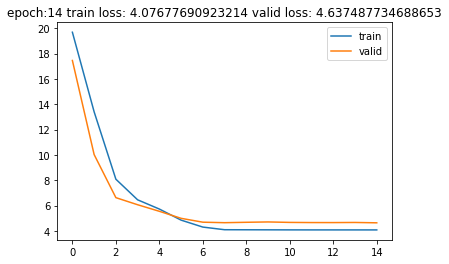

In [52]:
folderToDumpBinarization = folderToDump + "_noAugModifiedFullBinSep2"
y = 3
#for dice, ce in zip([0, 1,0.5,1,2,5], [1,0,1,1,1]):
#for dice, ce in zip([2], [1]):
l1 = 10
fm = 10
pm = 1

#coefs = {"finalMap":10, "probMap":10, "L1Final":100, "Dice" : 0, "CE" : 0, "charMap" : 0}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 10, "charMap" : 0}
#coefs = {"finalMap":2, "probMap":2, "L1Final":2, "Dice" : 2, "CE" : 10, "Dice0" : 2, "CE0" : 10,"charMap" : 2}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0,  "Dice" : 10, "CE" : 20,"charMap" : 20}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 10, "CE" : 20, "Dice0" : 10, "CE0" : 20,"charMap" : 20, "WordFL":50,"y":y}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "Dice0":0, "CE0":0,"charMap" : 0, "WordFL":50,"y":y}
coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 10, "CE" : 10, "Dice0":10, "CE0":10,"charMap" : 10, "WordFL":0,"y":y}

#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "Dice0" : 0, "CE0" : 0,"charMap" : 200}
#coefs = {"charMap" : 10}

#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "Dice0" : 0, "CE0" : 0,"charMap" : 2}
epoch_num = 100

epoch_num = 50
lr = 1e-3
optimizer = torch.optim.Adam(binarizer.parameters(), lr)
lossFuncs = dict()
lossFuncs["finalMap"] = torch.nn.BCELoss()
lossFuncs["probMap"] = torch.nn.BCELoss()
lossFuncs["L1Final"] = torch.nn.L1Loss()
lossFuncs["CE"] = FocalLoss(y)
lossFuncs["WordFL"] = FocalLossByWords(y)
lossFuncs["Dice"] = DiceLoss()
lossFuncs["CE0"] = FocalLoss(y)
lossFuncs["Dice0"] = DiceLoss()
lossFuncs["charMap"] = Maploss(minThreshold=0.1)#torch.nn.MSELoss()#Maploss()

# epoch_num = 15
# lr = 1e-5
# folderToDumpBinarization = folderToDump + "binarizationCharMapFreeze"
# train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
#       epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[8,12], \
#       coefs = coefs)

epoch_num = 15
lr = 1e-6
#folderToDumpBinarization = folderToDump + "binarizationCharMap"
train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
      epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[7,11], \
      coefs = coefs, trainDataset=train_dataset1, validDataset=valid_dataset)

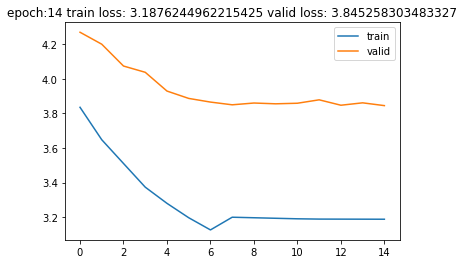

In [53]:
folderToDumpBinarization = folderToDump + "_noAugModifiedFullBinSep2"
y = 3
#for dice, ce in zip([0, 1,0.5,1,2,5], [1,0,1,1,1]):
#for dice, ce in zip([2], [1]):
l1 = 10
fm = 10
pm = 1

#coefs = {"finalMap":10, "probMap":10, "L1Final":100, "Dice" : 0, "CE" : 0, "charMap" : 0}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 10, "charMap" : 0}
#coefs = {"finalMap":2, "probMap":2, "L1Final":2, "Dice" : 2, "CE" : 10, "Dice0" : 2, "CE0" : 10,"charMap" : 2}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0,  "Dice" : 10, "CE" : 20,"charMap" : 20}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 10, "CE" : 20, "Dice0" : 10, "CE0" : 20,"charMap" : 20, "WordFL":50,"y":y}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "Dice0":0, "CE0":0,"charMap" : 0, "WordFL":50,"y":y}
coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 10, "CE" : 0, "Dice0":10, "CE0":0,"charMap" : 10, "WordFL":0,"y":y}

#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "Dice0" : 0, "CE0" : 0,"charMap" : 200}
#coefs = {"charMap" : 10}

#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "Dice0" : 0, "CE0" : 0,"charMap" : 2}
epoch_num = 100

epoch_num = 50
lr = 1e-3
optimizer = torch.optim.Adam(binarizer.parameters(), lr)
lossFuncs = dict()
lossFuncs["finalMap"] = torch.nn.BCELoss()
lossFuncs["probMap"] = torch.nn.BCELoss()
lossFuncs["L1Final"] = torch.nn.L1Loss()
lossFuncs["CE"] = FocalLoss(y)
lossFuncs["WordFL"] = FocalLossByWords(y)
lossFuncs["Dice"] = DiceLoss()
lossFuncs["CE0"] = FocalLoss(y)
lossFuncs["Dice0"] = DiceLoss()
lossFuncs["charMap"] = Maploss(minThreshold=0.1)#torch.nn.MSELoss()#Maploss()

# epoch_num = 15
# lr = 1e-5
# folderToDumpBinarization = folderToDump + "binarizationCharMapFreeze"
# train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
#       epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[8,12], \
#       coefs = coefs)

epoch_num = 15
lr = 1e-6
#folderToDumpBinarization = folderToDump + "binarizationCharMap"
train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
      epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[7,11], \
      coefs = coefs, trainDataset=train_dataset1, validDataset=valid_dataset)

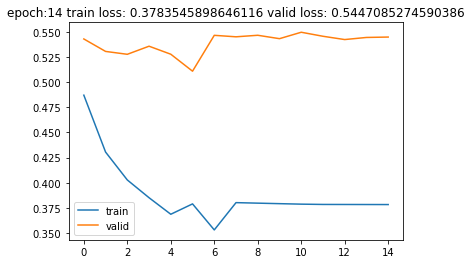

In [54]:
folderToDumpBinarization = folderToDump + "_noAugModifiedFullBinSep2"
y = 3
#for dice, ce in zip([0, 1,0.5,1,2,5], [1,0,1,1,1]):
#for dice, ce in zip([2], [1]):
l1 = 10
fm = 10
pm = 1

#coefs = {"finalMap":10, "probMap":10, "L1Final":100, "Dice" : 0, "CE" : 0, "charMap" : 0}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 10, "charMap" : 0}
#coefs = {"finalMap":2, "probMap":2, "L1Final":2, "Dice" : 2, "CE" : 10, "Dice0" : 2, "CE0" : 10,"charMap" : 2}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0,  "Dice" : 10, "CE" : 20,"charMap" : 20}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 10, "CE" : 20, "Dice0" : 10, "CE0" : 20,"charMap" : 20, "WordFL":50,"y":y}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "Dice0":0, "CE0":0,"charMap" : 0, "WordFL":50,"y":y}
coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 10, "Dice0":0, "CE0":10,"charMap" : 10, "WordFL":0,"y":y}

#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "Dice0" : 0, "CE0" : 0,"charMap" : 200}
#coefs = {"charMap" : 10}

#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "Dice0" : 0, "CE0" : 0,"charMap" : 2}
epoch_num = 100

epoch_num = 50
lr = 1e-3
optimizer = torch.optim.Adam(binarizer.parameters(), lr)
lossFuncs = dict()
lossFuncs["finalMap"] = torch.nn.BCELoss()
lossFuncs["probMap"] = torch.nn.BCELoss()
lossFuncs["L1Final"] = torch.nn.L1Loss()
lossFuncs["CE"] = FocalLoss(y)
lossFuncs["WordFL"] = FocalLossByWords(y)
lossFuncs["Dice"] = DiceLoss()
lossFuncs["CE0"] = FocalLoss(y)
lossFuncs["Dice0"] = DiceLoss()
lossFuncs["charMap"] = Maploss(minThreshold=0.1)#torch.nn.MSELoss()#Maploss()

# epoch_num = 15
# lr = 1e-5
# folderToDumpBinarization = folderToDump + "binarizationCharMapFreeze"
# train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
#       epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[8,12], \
#       coefs = coefs)

epoch_num = 15
lr = 1e-6
#folderToDumpBinarization = folderToDump + "binarizationCharMap"
train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
      epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[7,11], \
      coefs = coefs, trainDataset=train_dataset1, validDataset=valid_dataset)

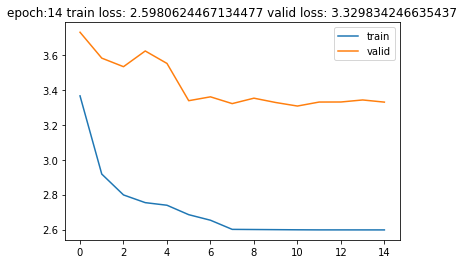

In [55]:
folderToDumpBinarization = folderToDump + "_noAugModifiedFullBinSep2"
y = 3
#for dice, ce in zip([0, 1,0.5,1,2,5], [1,0,1,1,1]):
#for dice, ce in zip([2], [1]):
l1 = 10
fm = 10
pm = 1

#coefs = {"finalMap":10, "probMap":10, "L1Final":100, "Dice" : 0, "CE" : 0, "charMap" : 0}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 10, "charMap" : 0}
#coefs = {"finalMap":2, "probMap":2, "L1Final":2, "Dice" : 2, "CE" : 10, "Dice0" : 2, "CE0" : 10,"charMap" : 2}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0,  "Dice" : 10, "CE" : 20,"charMap" : 20}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 10, "CE" : 20, "Dice0" : 10, "CE0" : 20,"charMap" : 20, "WordFL":50,"y":y}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "Dice0":0, "CE0":0,"charMap" : 0, "WordFL":50,"y":y}
coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 10, "CE" : 20, "Dice0":10, "CE0":20,"charMap" : 0, "WordFL":0,"y":y}

#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "Dice0" : 0, "CE0" : 0,"charMap" : 200}
#coefs = {"charMap" : 10}

#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "Dice0" : 0, "CE0" : 0,"charMap" : 2}
epoch_num = 100

epoch_num = 50
lr = 1e-3
optimizer = torch.optim.Adam(binarizer.parameters(), lr)
lossFuncs = dict()
lossFuncs["finalMap"] = torch.nn.BCELoss()
lossFuncs["probMap"] = torch.nn.BCELoss()
lossFuncs["L1Final"] = torch.nn.L1Loss()
lossFuncs["CE"] = FocalLoss(y)
lossFuncs["WordFL"] = FocalLossByWords(y)
lossFuncs["Dice"] = DiceLoss()
lossFuncs["CE0"] = FocalLoss(y)
lossFuncs["Dice0"] = DiceLoss()
lossFuncs["charMap"] = Maploss(minThreshold=0.1)#torch.nn.MSELoss()#Maploss()

# epoch_num = 15
# lr = 1e-5
# folderToDumpBinarization = folderToDump + "binarizationCharMapFreeze"
# train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
#       epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[8,12], \
#       coefs = coefs)

epoch_num = 15
lr = 1e-6
#folderToDumpBinarization = folderToDump + "binarizationCharMap"
train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
      epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[7,11], \
      coefs = coefs, trainDataset=train_dataset1, validDataset=valid_dataset)

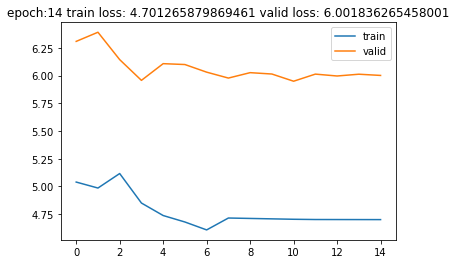

In [56]:
folderToDumpBinarization = folderToDump + "_noAugModifiedFullBinSep2"
y = 3
#for dice, ce in zip([0, 1,0.5,1,2,5], [1,0,1,1,1]):
#for dice, ce in zip([2], [1]):
l1 = 10
fm = 10
pm = 1

#coefs = {"finalMap":10, "probMap":10, "L1Final":100, "Dice" : 0, "CE" : 0, "charMap" : 0}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 10, "charMap" : 0}
#coefs = {"finalMap":2, "probMap":2, "L1Final":2, "Dice" : 2, "CE" : 10, "Dice0" : 2, "CE0" : 10,"charMap" : 2}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0,  "Dice" : 10, "CE" : 20,"charMap" : 20}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 10, "CE" : 20, "Dice0" : 10, "CE0" : 20,"charMap" : 20, "WordFL":50,"y":y}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "Dice0":0, "CE0":0,"charMap" : 0, "WordFL":50,"y":y}
coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 20, "CE" : 20, "Dice0":20, "CE0":10,"charMap" : 0, "WordFL":0,"y":y}

#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "Dice0" : 0, "CE0" : 0,"charMap" : 200}
#coefs = {"charMap" : 10}

#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "Dice0" : 0, "CE0" : 0,"charMap" : 2}
epoch_num = 100

epoch_num = 50
lr = 1e-3
optimizer = torch.optim.Adam(binarizer.parameters(), lr)
lossFuncs = dict()
lossFuncs["finalMap"] = torch.nn.BCELoss()
lossFuncs["probMap"] = torch.nn.BCELoss()
lossFuncs["L1Final"] = torch.nn.L1Loss()
lossFuncs["CE"] = FocalLoss(y)
lossFuncs["WordFL"] = FocalLossByWords(y)
lossFuncs["Dice"] = DiceLoss()
lossFuncs["CE0"] = FocalLoss(y)
lossFuncs["Dice0"] = DiceLoss()
lossFuncs["charMap"] = Maploss(minThreshold=0.1)#torch.nn.MSELoss()#Maploss()

# epoch_num = 15
# lr = 1e-5
# folderToDumpBinarization = folderToDump + "binarizationCharMapFreeze"
# train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
#       epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[8,12], \
#       coefs = coefs)

epoch_num = 15
lr = 1e-6
#folderToDumpBinarization = folderToDump + "binarizationCharMap"
train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
      epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[7,11], \
      coefs = coefs, trainDataset=train_dataset1, validDataset=valid_dataset)

In [57]:
torch.int64

torch.int64

In [58]:
dasda

NameError: name 'dasda' is not defined

In [ ]:
modelPath = R"D:\Data\Diploma\dumps\binarizationModifNoAugCharMapSep\finalMap0probMap0L1Final0Dice10CE20Dice010CE020charMap200\34"
binarizer.load_state_dict(torch.load(modelPath))

folderToDumpBinarization = folderToDump + "binarizationModifNoAugCharMapSepReal"

y = 1
#for dice, ce in zip([0, 1,0.5,1,2,5], [1,0,1,1,1]):
#for dice, ce in zip([2], [1]):
l1 = 10
fm = 10
pm = 1

#coefs = {"finalMap":10, "probMap":10, "L1Final":100, "Dice" : 0, "CE" : 0, "charMap" : 0}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "charMap" : 10}
#coefs = {"finalMap":2, "probMap":2, "L1Final":2, "Dice" : 2, "CE" : 10, "Dice0" : 2, "CE0" : 10,"charMap" : 2}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0,  "Dice" : 10, "CE" : 20,"charMap" : 20}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 10, "CE" : 20, "Dice0" : 10, "CE0" : 20,"charMap" : 200}
coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "Dice0" : 0, "CE0" : 0,"charMap" : 200}
#coefs = {"charMap" : 10}

#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "Dice0" : 0, "CE0" : 0,"charMap" : 2}
epoch_num = 100

epoch_num = 50
lr = 1e-3
optimizer = torch.optim.Adam(binarizer.parameters(), lr)
lossFuncs = dict()
lossFuncs["finalMap"] = torch.nn.BCELoss()
lossFuncs["probMap"] = torch.nn.BCELoss()
lossFuncs["L1Final"] = torch.nn.L1Loss()
lossFuncs["CE"] = FocalLoss(y)
lossFuncs["Dice"] = DiceLoss()
lossFuncs["CE0"] = FocalLoss(y)
lossFuncs["Dice0"] = DiceLoss()
lossFuncs["charMap"] = Maploss(minThreshold=0.1)#torch.nn.MSELoss()#Maploss()

# epoch_num = 15
# lr = 1e-5
# folderToDumpBinarization = folderToDump + "binarizationCharMapFreeze"
# train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
#       epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[8,12], \
#       coefs = coefs)

epoch_num = 35
lr = 1e-12
#folderToDumpBinarization = folderToDump + "binarizationCharMap"
train(real_dataLoader, valid_dataLoader, binarizer, optimizer, lossFuncs,\
      epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[10,25], \
      coefs = coefs)

In [ ]:
ew

In [ ]:
y = 1
#for dice, ce in zip([0, 1,0.5,1,2,5], [1,0,1,1,1]):
#for dice, ce in zip([2], [1]):
l1 = 10
fm = 10
pm = 1

#coefs = {"finalMap":10, "probMap":10, "L1Final":100, "Dice" : 0, "CE" : 0, "charMap" : 0}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "charMap" : 10}
#coefs = {"finalMap":2, "probMap":2, "L1Final":2, "Dice" : 2, "CE" : 10, "Dice0" : 2, "CE0" : 10,"charMap" : 2}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0,  "Dice" : 10, "CE" : 20,"charMap" : 20}
coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 10, "CE" : 200, "Dice0" : 10, "CE0" : 200,"charMap" : 20}
#coefs = {"charMap" : 10}

#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "Dice0" : 0, "CE0" : 0,"charMap" : 2}
epoch_num = 100

epoch_num = 50
lr = 1e-3
optimizer = torch.optim.Adam(binarizer.parameters(), lr)
lossFuncs = dict()
lossFuncs["finalMap"] = torch.nn.BCELoss()
lossFuncs["probMap"] = torch.nn.BCELoss()
lossFuncs["L1Final"] = torch.nn.L1Loss()
lossFuncs["CE"] = FocalLoss(y)
lossFuncs["Dice"] = DiceLoss()
lossFuncs["CE0"] = FocalLoss(y)
lossFuncs["Dice0"] = DiceLoss()
lossFuncs["charMap"] = Maploss(minThreshold=0.1)#torch.nn.MSELoss()#Maploss()

# epoch_num = 15
# lr = 1e-5
# folderToDumpBinarization = folderToDump + "binarizationCharMapFreeze"
# train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
#       epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[8,12], \
#       coefs = coefs)

epoch_num = 35
lr = 1e-6
#folderToDumpBinarization = folderToDump + "binarizationCharMap"
train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
      epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[10,25], \
      coefs = coefs)

In [ ]:
y = 1
#for dice, ce in zip([0, 1,0.5,1,2,5], [1,0,1,1,1]):
#for dice, ce in zip([2], [1]):
l1 = 10
fm = 10
pm = 1

#coefs = {"finalMap":10, "probMap":10, "L1Final":100, "Dice" : 0, "CE" : 0, "charMap" : 0}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "charMap" : 10}
#coefs = {"finalMap":2, "probMap":2, "L1Final":2, "Dice" : 2, "CE" : 10, "Dice0" : 2, "CE0" : 10,"charMap" : 2}
#coefs = {"finalMap":0, "probMap":0, "L1Final":0,  "Dice" : 10, "CE" : 20,"charMap" : 20}
coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 100, "CE" : 20, "Dice0" : 100, "CE0" : 20,"charMap" : 20}
#coefs = {"charMap" : 10}

#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "Dice0" : 0, "CE0" : 0,"charMap" : 2}
epoch_num = 100

epoch_num = 50
lr = 1e-3
optimizer = torch.optim.Adam(binarizer.parameters(), lr)
lossFuncs = dict()
lossFuncs["finalMap"] = torch.nn.BCELoss()
lossFuncs["probMap"] = torch.nn.BCELoss()
lossFuncs["L1Final"] = torch.nn.L1Loss()
lossFuncs["CE"] = FocalLoss(y)
lossFuncs["Dice"] = DiceLoss()
lossFuncs["CE0"] = FocalLoss(y)
lossFuncs["Dice0"] = DiceLoss()
lossFuncs["charMap"] = Maploss(minThreshold=0.1)#torch.nn.MSELoss()#Maploss()

# epoch_num = 15
# lr = 1e-5
# folderToDumpBinarization = folderToDump + "binarizationCharMapFreeze"
# train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
#       epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[8,12], \
#       coefs = coefs)

epoch_num = 35
lr = 1e-6
#folderToDumpBinarization = folderToDump + "binarizationCharMap"
train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
      epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[10,25], \
      coefs = coefs)

In [ ]:
dsfds

In [ ]:
folderToDumpBinarization = folderToDump + "binarizationWithPreBinRealOnTrain"


In [ ]:
y = 5
#for dice, ce in zip([0, 1,0.5,1,2,5], [1,0,1,1,1]):
#for dice, ce in zip([2], [1]):
l1 = 10
fm = 10
pm = 1

coefs = {"finalMap":10, "probMap":10, "L1Final":0.01, "Dice" : 20, "CE" : 10, "charMap" : 10}
coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "charMap" : 10}
#coefs = {"finalMap":2, "probMap":2, "L1Final":2, "Dice" : 2, "CE" : 10, "Dice0" : 2, "CE0" : 10,"charMap" : 2}
coefs = {"finalMap":2, "probMap":2, "L1Final":2, "Dice" : 0, "CE" : 0, "Dice0" : 0, "CE0" : 0,"charMap" : 2}
coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 10, "CE" : 20, "Dice0" : 10, "CE0" : 20,"charMap" : 2}
#coefs = {"charMap" : 10}

#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "Dice0" : 0, "CE0" : 0,"charMap" : 2}
epoch_num = 100

epoch_num = 50
lr = 1e-3
optimizer = torch.optim.Adam(binarizer.parameters(), lr)
lossFuncs = dict()
lossFuncs["finalMap"] = torch.nn.BCELoss()
lossFuncs["probMap"] = torch.nn.BCELoss()
lossFuncs["L1Final"] = torch.nn.L1Loss()
lossFuncs["CE"] = FocalLoss(y)
lossFuncs["Dice"] = DiceLoss()
lossFuncs["CE0"] = FocalLoss(y)
lossFuncs["Dice0"] = DiceLoss()
lossFuncs["charMap"] = Maploss(minThreshold=0.1)#torch.nn.MSELoss()#Maploss()

# epoch_num = 15
# lr = 1e-5
# folderToDumpBinarization = folderToDump + "binarizationCharMapFreeze"
# train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
#       epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[8,12], \
#       coefs = coefs)

epoch_num = 2
lr = 1e-15
#folderToDumpBinarization = folderToDump + "binarizationCharMap"
train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
      epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[10,17], \
      coefs = coefs)

In [ ]:
y = 5
#for dice, ce in zip([0, 1,0.5,1,2,5], [1,0,1,1,1]):
#for dice, ce in zip([2], [1]):
l1 = 10
fm = 10
pm = 1

coefs = {"finalMap":10, "probMap":10, "L1Final":0.01, "Dice" : 20, "CE" : 10, "charMap" : 10}
coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "charMap" : 10}
#coefs = {"finalMap":2, "probMap":2, "L1Final":2, "Dice" : 2, "CE" : 10, "Dice0" : 2, "CE0" : 10,"charMap" : 2}
coefs = {"finalMap":2, "probMap":2, "L1Final":2, "Dice" : 0, "CE" : 0, "Dice0" : 0, "CE0" : 0,"charMap" : 2}
coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 5, "CE" : 20, "Dice0" : 5, "CE0" : 20,"charMap" : 2}
#coefs = {"charMap" : 10}

#coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "Dice0" : 0, "CE0" : 0,"charMap" : 2}
epoch_num = 100

epoch_num = 50
lr = 1e-3
optimizer = torch.optim.Adam(binarizer.parameters(), lr)
lossFuncs = dict()
lossFuncs["finalMap"] = torch.nn.BCELoss()
lossFuncs["probMap"] = torch.nn.BCELoss()
lossFuncs["L1Final"] = torch.nn.L1Loss()
lossFuncs["CE"] = FocalLoss(y)
lossFuncs["Dice"] = DiceLoss()
lossFuncs["CE0"] = FocalLoss(y)
lossFuncs["Dice0"] = DiceLoss()
lossFuncs["charMap"] = Maploss(minThreshold=0.1)#torch.nn.MSELoss()#Maploss()

# epoch_num = 15
# lr = 1e-5
# folderToDumpBinarization = folderToDump + "binarizationCharMapFreeze"
# train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
#       epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[8,12], \
#       coefs = coefs)

epoch_num = 25
lr = 1e-6
folderToDumpBinarization = folderToDump + "binarizationCharMap"
train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
      epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[10,17], \
      coefs = coefs)

In [ ]:
jhkh

In [ ]:
lr = 1e-10
folderToDumpBinarization = folderToDump + "binarizationCharMap3"
# train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,
#       epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= freezeBackBone, reduceLR=[25,35], \
#       coefs = coefs)

In [ ]:
y = 5
#for dice, ce in zip([0, 1,0.5,1,2,5], [1,0,1,1,1]):
#for dice, ce in zip([2], [1]):
l1 = 10
fm = 10
pm = 1

coefs = {"finalMap":10, "probMap":10, "L1Final":0.01, "Dice" : 20, "CE" : 10, "charMap" : 10}
coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "charMap" : 10}
#coefs = {"finalMap":2, "probMap":2, "L1Final":2, "Dice" : 2, "CE" : 10, "Dice0" : 2, "CE0" : 10,"charMap" : 2}
coefs = {"finalMap":2, "probMap":2, "L1Final":2, "Dice" : 0, "CE" : 0, "Dice0" : 0, "CE0" : 0,"charMap" : 2}
coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 2, "CE" : 20, "Dice0" : 2, "CE0" : 20,"charMap" : 2}
#coefs = {"charMap" : 10}


epoch_num = 100

epoch_num = 50
lr = 1e-3
optimizer = torch.optim.Adam(binarizer.parameters(), lr)
lossFuncs = dict()
lossFuncs["finalMap"] = torch.nn.BCELoss()
lossFuncs["probMap"] = torch.nn.BCELoss()
lossFuncs["L1Final"] = torch.nn.L1Loss()
lossFuncs["CE"] = FocalLoss(y)
lossFuncs["Dice"] = DiceLoss()
lossFuncs["CE0"] = FocalLoss(y)
lossFuncs["Dice0"] = DiceLoss()
lossFuncs["charMap"] = Maploss(minThreshold=0.1)#torch.nn.MSELoss()#Maploss()

# epoch_num = 15
# lr = 1e-5
# folderToDumpBinarization = folderToDump + "binarizationCharMapFreeze"
# train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
#       epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[8,12], \
#       coefs = coefs)

epoch_num = 50
lr = 1e-3
folderToDumpBinarization = folderToDump + "binarizationCharMap"
train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
      epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[25,35], \
      coefs = coefs)

In [ ]:
dasd

In [ ]:
epoch_num = 50
lr = 1e-6
folderToDumpBinarization = folderToDump + "binarizationCharMap"
train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
      epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= None, reduceLR=[25,35], \
      coefs = coefs)

In [ ]:
dsds

In [ ]:
binarizer = Binarizer().to(device)

In [ ]:
y = 0.5
#for dice, ce in zip([0, 1,0.5,1,2,5], [1,0,1,1,1]):
#for dice, ce in zip([2], [1]):
l1 = 10
fm = 10
pm = 1

coefs = {"finalMap":10, "probMap":10, "L1Final":0.01, "Dice" : 20, "CE" : 10, "charMap" : 10}
coefs = {"finalMap":0, "probMap":0, "L1Final":0, "Dice" : 0, "CE" : 0, "charMap" : 10}
coefs = {"charMap" : 11}


epoch_num = 100

epoch_num = 50
lr = 1e-5
optimizer = torch.optim.Adam(binarizer.parameters(), lr)
lossFuncs = dict()
lossFuncs["finalMap"] = torch.nn.BCELoss()
lossFuncs["probMap"] = torch.nn.BCELoss()
lossFuncs["L1Final"] = torch.nn.L1Loss()
lossFuncs["CE"] = FocalLoss(y)
lossFuncs["Dice"] = DiceLoss()
lossFuncs["CE0"] = FocalLoss(y)
lossFuncs["Dice0"] = DiceLoss()
lossFuncs["charMap"] = torch.nn.MSELoss()#Maploss()

epoch_num = 15
lr = 1e-5
folderToDumpBinarization = folderToDump + "binarizationCharMapFreeze"
train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
      epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= freezeBackBone, reduceLR=[8,12], \
      coefs = coefs)

epoch_num = 50
lr = 1e-8
folderToDumpBinarization = folderToDump + "binarizationCharMap"
train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
      epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= freezeBackBone, reduceLR=[25,35], \
      coefs = coefs)

In [ ]:
ew

In [ ]:
y = 0.5
#for dice, ce in zip([0, 1,0.5,1,2,5], [1,0,1,1,1]):
#for dice, ce in zip([2], [1]):
for l1, fm, pm in zip([10, 20,50,5],[10,10,10,5],[0,0,1,0.5]):
    coefs = {"finalMap":fm, "probMap":pm, "L1Final":l1, "Dice" : 20, "CE" : 10}


    epoch_num = 100

    epoch_num = 25
    lr = 1e-5
    optimizer = torch.optim.Adam(binarizer.parameters(), lr)
    lossFuncs = dict()
    lossFuncs["finalMap"] = torch.nn.BCELoss()
    lossFuncs["probMap"] = torch.nn.BCELoss()
    lossFuncs["L1Final"] = torch.nn.L1Loss()
    lossFuncs["CE"] = FocalLoss(y)
    lossFuncs["Dice"] = DiceLoss()
    folderToDumpBinarization = folderToDump + "binarizationDiff"
    train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
          epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= freezeBackBone, reduceLR=[10,15], \
          coefs = coefs)

In [ ]:
fdhj

In [ ]:

dec = 0.5
cec = 0.5
y = 0.5
coefs = {"finalMap":1, "probMap":1, "L1Final":10, "Dice" : 10, "CE" : 10}

epoch_num = 100


lr = 1e-3
epoch_num = 15
optimizer = torch.optim.Adam(binarizer.parameters(), lr)
lossFuncs = dict()
lossFuncs["finalMap"] = torch.nn.BCELoss()
lossFuncs["probMap"] = torch.nn.BCELoss()
lossFuncs["L1Final"] = torch.nn.L1Loss()
lossFuncs["CE"] = FocalLoss(y)
lossFuncs["Dice"] = DiceLoss()
folderToDumpFreeze = folderToDump + "binarizationDiffFreezed/"
train(train_dataLoader1, valid_dataLoader, binarizer, optimizer, lossFuncs,\
      epoch_num, folderToDumpFreeze, learningRate=lr, freezeFunc= unfreezeAll, reduceLR=[5,10,13], \
      coefs = coefs)

modelPath = folderToDumpFreeze + "finalMap1probMap1L1Final10Dice10CE10/14"
binarizer.load_state_dict(torch.load(modelPath))


epoch_num = 50
lr = 1e-6
optimizer = torch.optim.Adam(binarizer.parameters(), lr)
lossFuncs = dict()
lossFuncs["finalMap"] = torch.nn.BCELoss()
lossFuncs["probMap"] = torch.nn.BCELoss()
lossFuncs["L1Final"] = torch.nn.L1Loss()
lossFuncs["CE"] = FocalLoss(y)
lossFuncs["Dice"] = DiceLoss()
folderToDumpBinarization = folderToDump + "binarizationDiff"
train(train_dataLoader3, valid_dataLoader, binarizer, optimize r, lossFuncs,\
      epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= unfreezeAll, reduceLR=[10,20,35], \
      coefs = coefs)

In [ ]:
dadsadsa

In [ ]:
value = 0.5
DiceCoeffs = [1, 2, 0.5, 5, 0.5]
CECoeffs = [  1, 1, 1,  0.5, 5]
Gamma = [0.5, 2, 5, 10]
len(DiceCoeffs) * len(Gamma)

In [ ]:
# for y in Gamma:
#     for dec in DiceCoeffs:
#         for cec in CECoeffs:
            

#             lr = 1e-5
#             epoch_num = 25
#             #dec = 0.5
#             #cec = 0.5
#             optimizer = torch.optim.Adam(binarizer.parameters(), lr)
#             loss_function_dice = DiceLoss()
#             loss_function_ce = FocalLoss(y)

# #             folderToDumpFreeze = folderToDump + "freezedBackBone/"
# #             modelPath = folderToDumpFreeze + "14"
# #             binarizer.load_state_dict(torch.load(modelPath))
#             folderToDumpBinarization = folderToDump + "binarizationNoAug2"
#             train(train_dataLoader, valid_dataLoader, binarizer, optimizer, loss_function_ce, loss_function_dice,\
#                   epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= unfreezeAll, reduceLR=[8,15,20], \
#                   coefs = {"Dice":dec, "CE":cec, "Gamma":y})
#         #    break
#       #  break
#     #break

In [ ]:
assa

In [ ]:
def calcIOU(dataloader, net):
    with torch.no_grad():
        net.eval()
        ious = []
        progress = tn(dataloader)
        for i, data in enumerate(progress):
            distortedImage, gtImage, binImages, annotation = data
            distortedImage = distortedImage.to(device)
            gtImage = gtImage.to(device)

            binLogits, binClasses, _ = net((distortedImage, binImages))
            #binClasses = binClasses.squeeze()
            iou = countIOU(binClasses[0].detach().cpu().squeeze().numpy(), gtImage[0].detach().cpu().squeeze().numpy())
            ious.append(iou)
            progress.set_description("iou: %f.3" % np.mean(ious))
            if i % 10 == 0:
                s = 5
                plt.figure(figsize=(s,s))
                plt.imshow(distortedImage[0].detach().squeeze().cpu().numpy().transpose(1,2,0))
                plt.show()
                plt.figure(figsize=(s,s))
                plt.imshow(binClasses[0].detach().squeeze().cpu().numpy(), cmap="binary")
                plt.show()
                plt.figure(figsize=(s,s))
                plt.imshow(gtImage[0].detach().cpu().squeeze().numpy(), cmap="binary")
                plt.show()
    return np.mean(ious)


In [ ]:
# ious = []
# coefss = []
# for y in Gamma:
#     for dec in DiceCoeffs:
#         for cec in CECoeffs:
            

#             coefs = {"Dice":dec, "CE":cec, "Gamma":y}

# #             folderToDumpFreeze = folderToDump + "freezedBackBone/"
# #             modelPath = folderToDumpFreeze + "14"
# #             binarizer.load_state_dict(torch.load(modelPath))
#             folderToDumpBinarization = folderToDump + "binarizationNoAug2/"
#             for item in coefs.items():
#                 folderToDumpBinarization += item[0] + str(item[1])
                
#             if not os.path.exists(folderToDumpBinarization):
#                 continue
#             #print("!")

#             modelPath = folderToDumpBinarization + "/24"
#             binarizer.load_state_dict(torch.load(modelPath))
            
#             iou = calcIOU(valid_dataLoader, binarizer)
#             ious.append(iou)
#             coefss.append(coefs)

In [ ]:
ious

In [ ]:
coefss

In [ ]:
folderToDumpBinarization = folderToDump + "/binarizationDiff\\finalMap0probMap0L1Final0Dice1CE0"
modelPath = folderToDumpBinarization + "/14"
binarizer.load_state_dict(torch.load(modelPath))

In [ ]:
folderToDumpBinarization = folderToDump + "/binarizationCharMap\\charMap10"
modelPath = folderToDumpBinarization + "/49"
binarizer.load_state_dict(torch.load(modelPath))

In [64]:
modelPath = R"D:\Data\Diploma\dumps\_noAugModifiedFullBinSep2\finalMap0probMap0L1Final0Dice10CE0Dice010CE00charMap10WordFL0y3"
modelPath = modelPath + R"\\14"
binarizer.load_state_dict(torch.load(modelPath))

<All keys matched successfully>

0000000.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


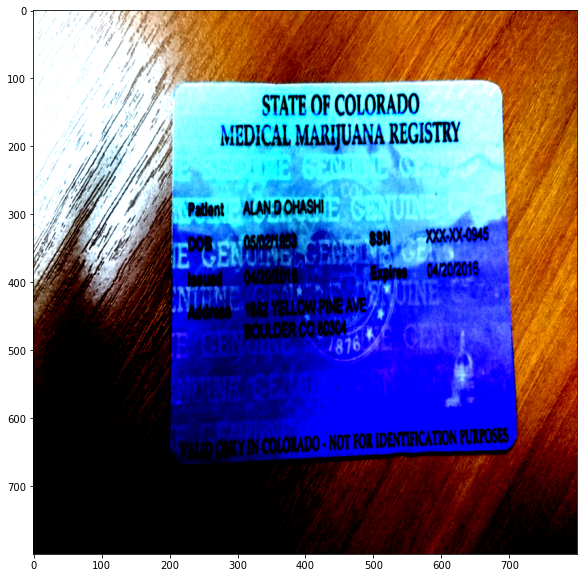

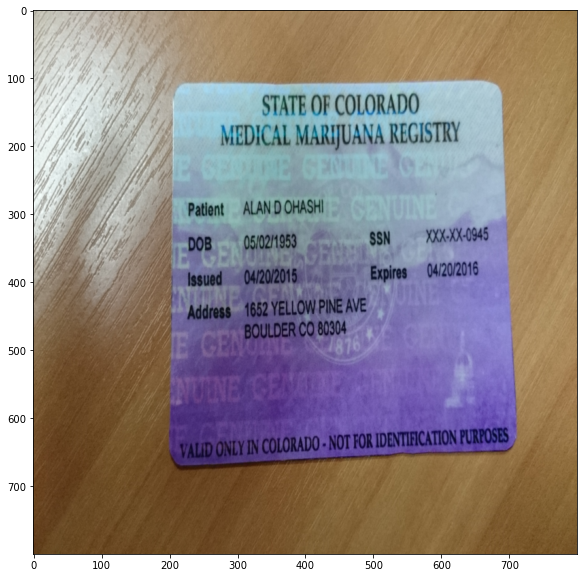

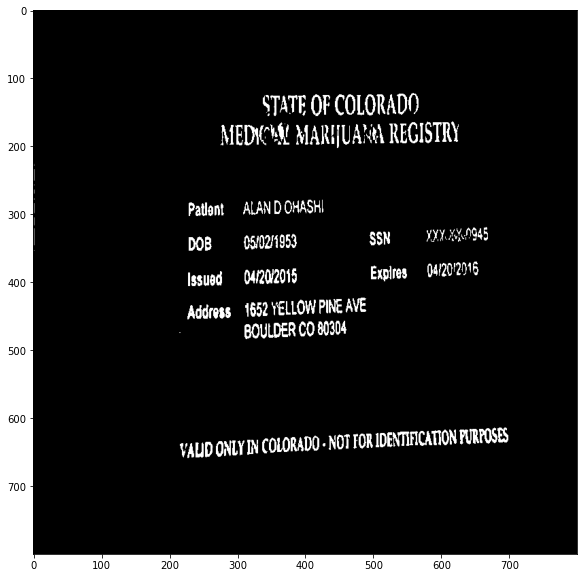

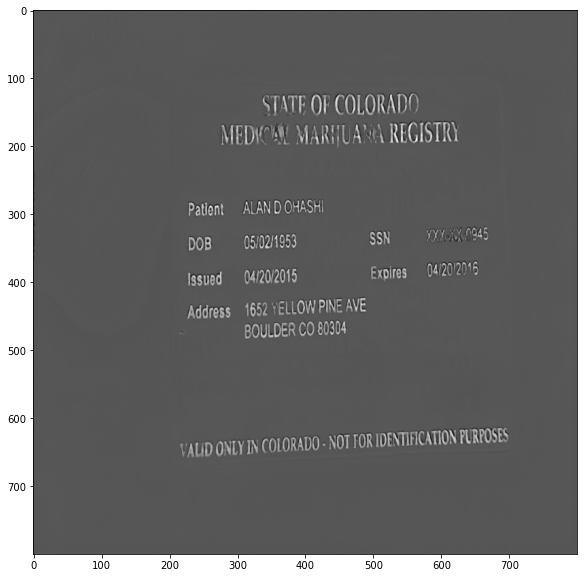

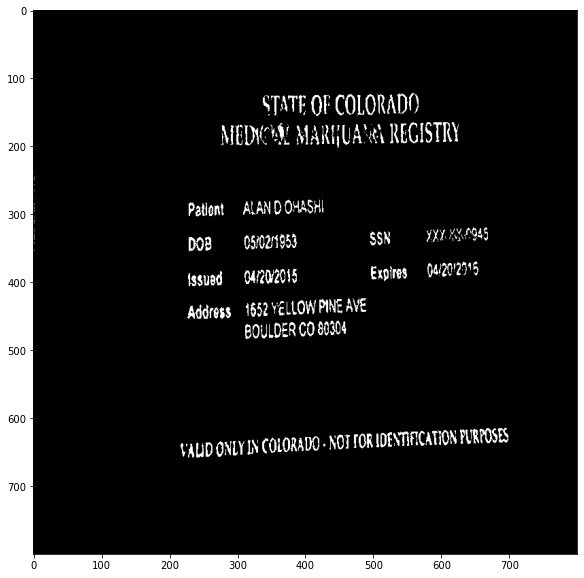

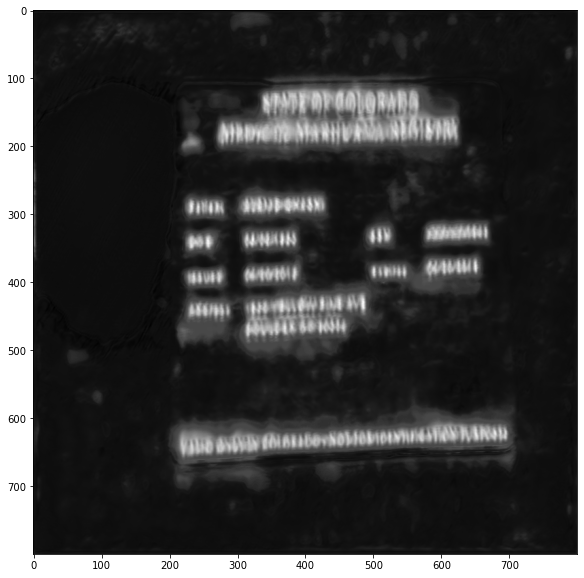

0000001.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


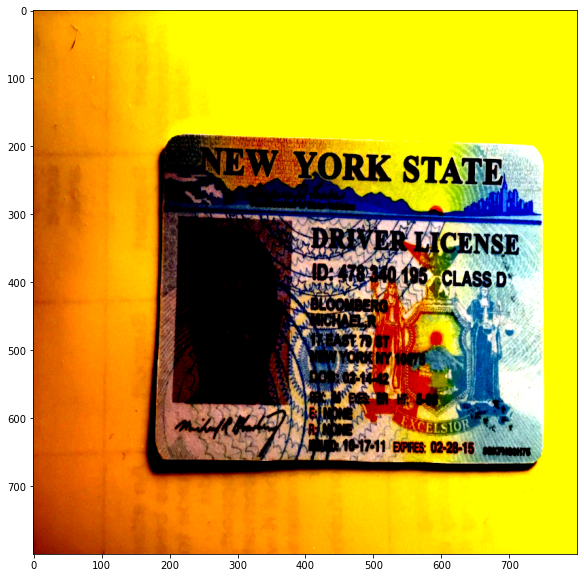

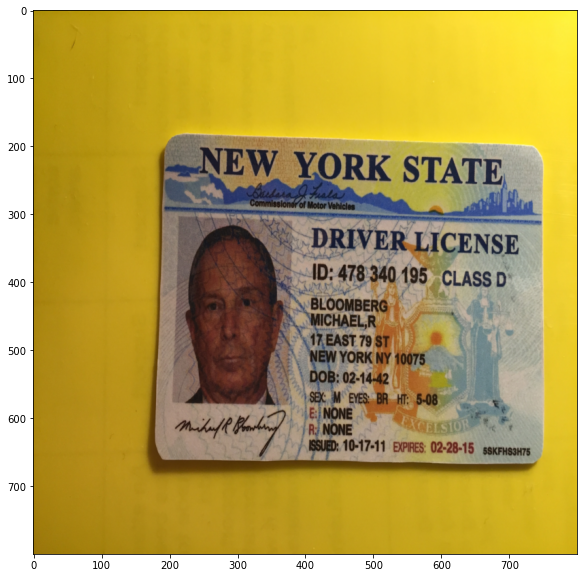

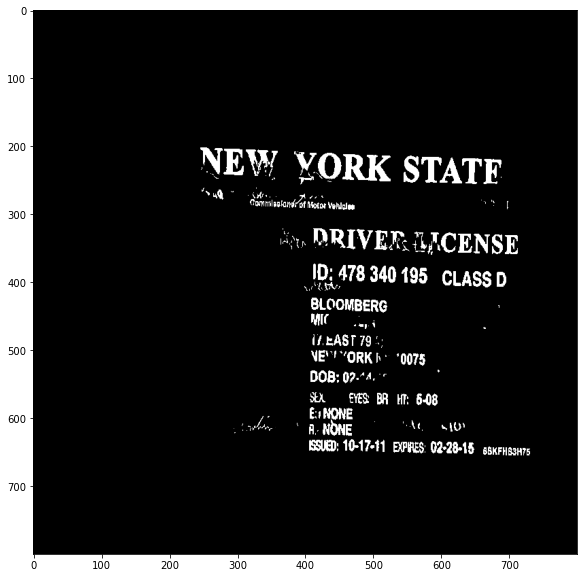

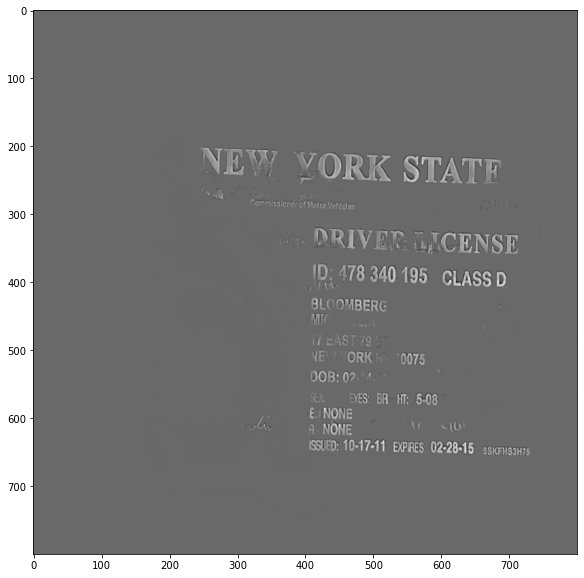

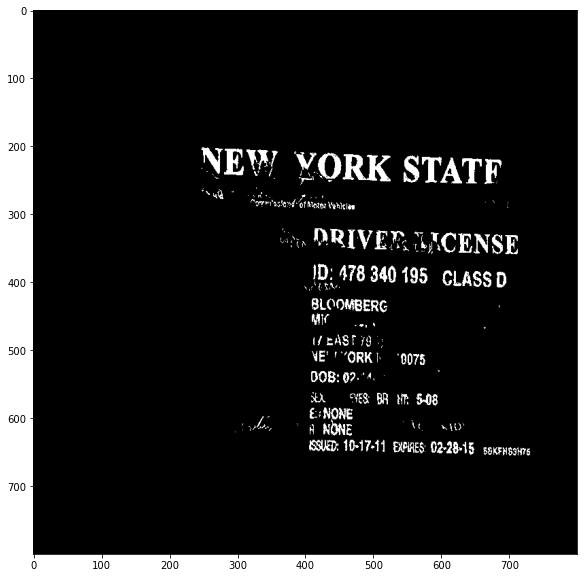

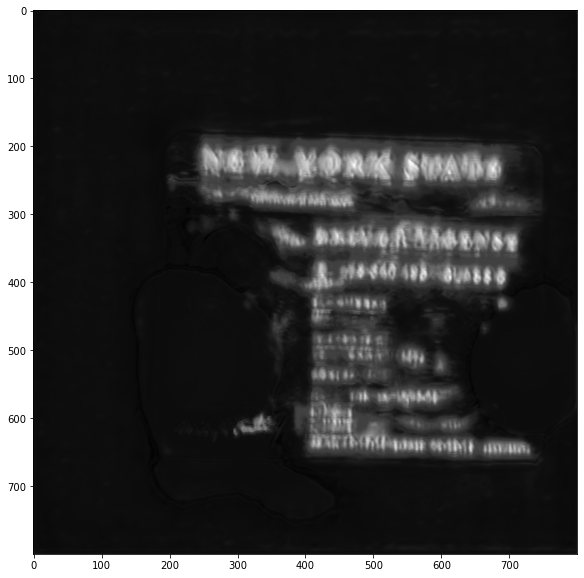

0000002.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


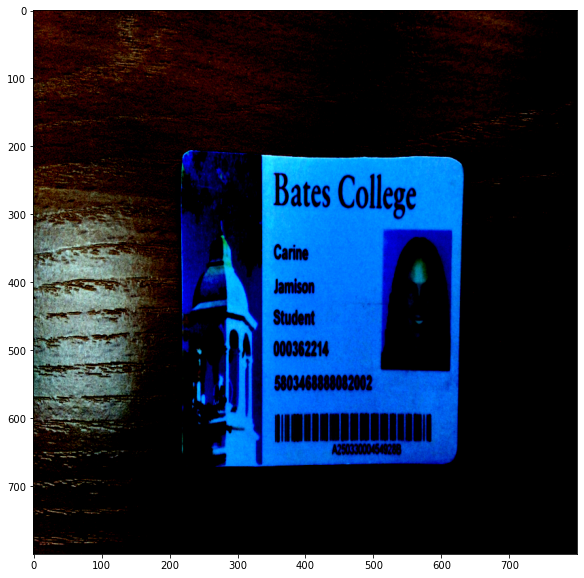

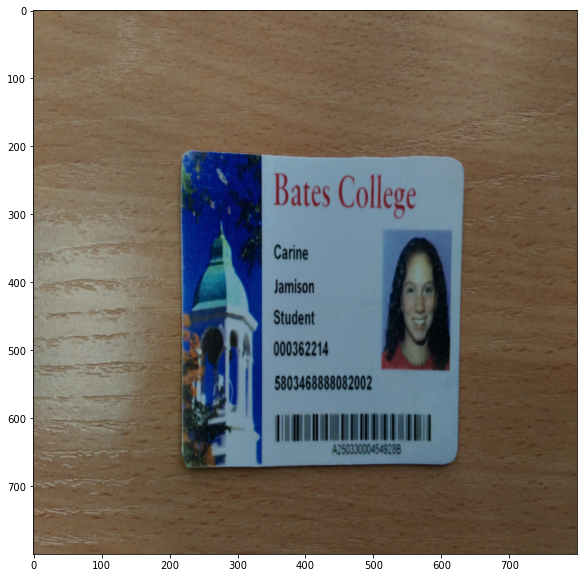

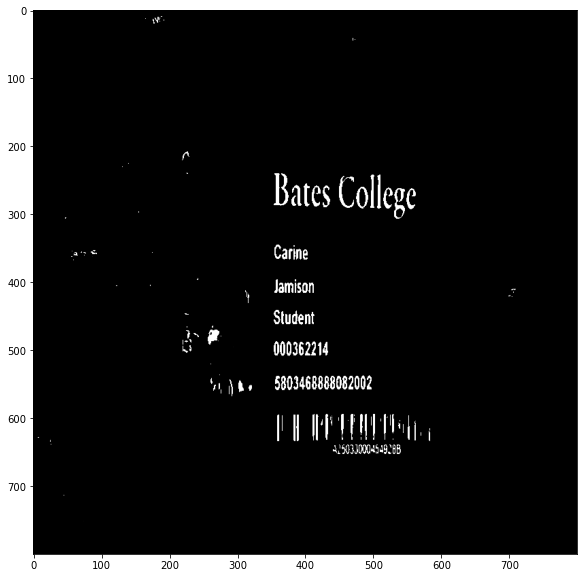

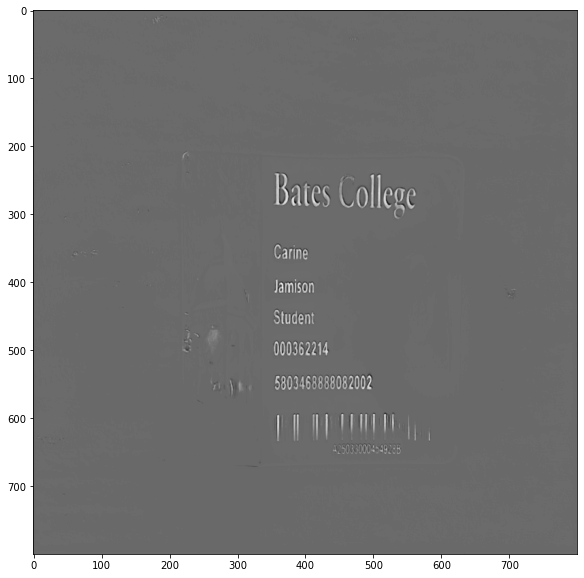

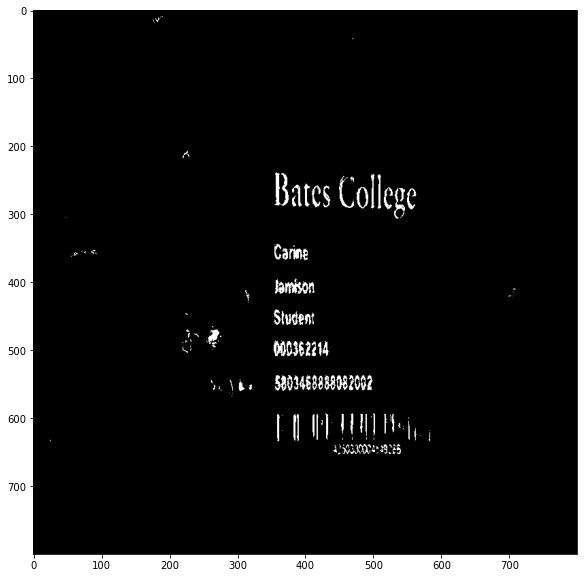

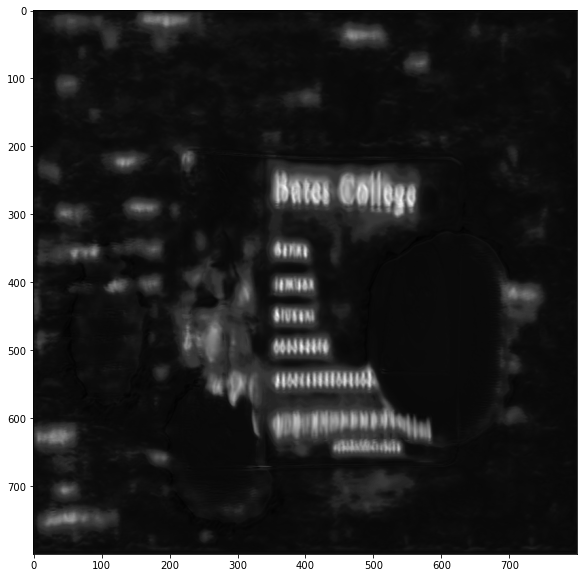

0000003.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


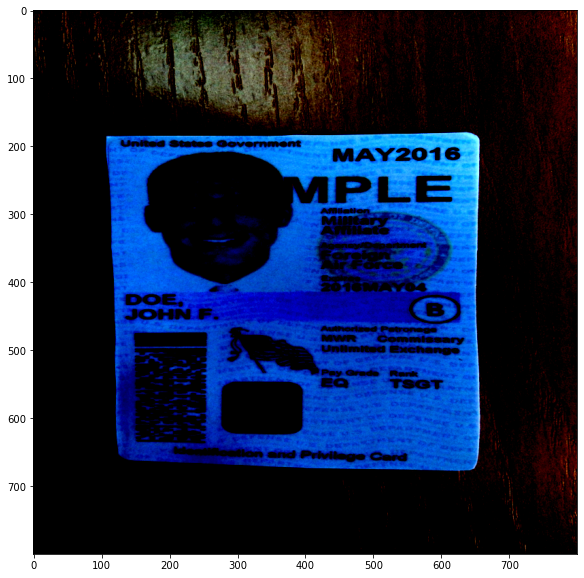

In [ ]:
pathToRealImages = R"D:\Data\Diploma\real\real\realInternet//"
pathToRealImages = R"D:\Data\Diploma\real\real\real\ARIZONAphotoUber12_all"
pathToRealImages = R"D:\Data\Diploma\real\real\real\Train_V2\American.ID_photo\Image"
#pathToRealImages = R"D:\Data\Diploma\real\real\real\newFloder"
#pathToRealImages = R"D:\Data\Diploma\real\real\real\Train_V2\Singapore.IC_photo\Image"
for imName in os.listdir(pathToRealImages):
    if "jpg" not in imName and "tif" not in imName and "jpeg" not in imName:
        continue
        
    print(imName)
    try:
        realImage = PIL.Image.open(os.path.join(pathToRealImages, imName))
    except:
        continue
    realImage, ratio = ResizeMinSide()(realImage)

    realImage = realImage.convert('RGB')
    binarized = binarize(realImage)
    realImage2 = realImage
    realImage = transf(realImage)
    binarized = torch.from_numpy(binarized).to(device).unsqueeze(0)


    with torch.no_grad():
        realImage = realImage.to(device)
        realImage = realImage.unsqueeze(0)
        out = binarizer((realImage, binarized))
        s = 10
#         #binClasses = binClasses.squeeze()
#         iou = countIOU(out["topClass"][0].detach().cpu().squeeze().numpy(), realImage[0].detach().cpu().squeeze().numpy())
        
#         #iou = countIOU(out["train"]["finalMap"][0].detach().cpu().squeeze().numpy(), realImage[0].detach().cpu().squeeze().numpy())
#         print(iou)
#         
        plt.figure(figsize=(s,s))
        plt.imshow(realImage[0].detach().squeeze().cpu().numpy().transpose(1,2,0))
        plt.show()
        plt.figure(figsize=(s,s))
        plt.imshow(np.array(realImage2))
        plt.show()
        plt.figure(figsize=(s,s))
        plt.imshow(torch.sigmoid(out["train"]["Dice"]).detach().squeeze().cpu().numpy(), cmap="gray")
        plt.show()
        plt.figure(figsize=(s,s))
        plt.imshow(out["train"]["CE0"][0][0].detach().squeeze().cpu().numpy(), cmap="gray")
        plt.show()
        plt.figure(figsize=(s,s))
        plt.imshow(out["topClass"][0].detach().squeeze().cpu().numpy(), cmap="gray")
        plt.show()
#         plt.figure(figsize=(s,s))
#         plt.imshow(out["train"]["finalMap"][0].detach().squeeze().cpu().numpy(), cmap="binary")
#         plt.show()
        plt.figure(figsize=(s,s))
        plt.imshow(out["train"]["charMap"][0].detach().squeeze().cpu().numpy(), cmap="gray")
        plt.show()
        pathToSaveResult = os.path.join(pathToRealImages, "result")
        os.makedirs(pathToSaveResult, exist_ok=True)
        cv2.imwrite(os.path.join(pathToSaveResult, imName + ".jpg"), out["topClass"][0].detach().squeeze().cpu().numpy()*255)
        
        

In [ ]:
image = np.array(out["topClass"][0].detach().int().cpu().numpy(), dtype=np.float32)

In [ ]:
cv2.imwrite(os.path.join(pathToSaveResult, imName + ".png"), image)

In [ ]:
os.path.join(pathToSaveResult, imName + ".png")

In [ ]:
np.array(out["topClass"][0].detach().int().cpu().numpy(),dtype=np.int8)

In [ ]:
out["topClass"][0].detach().squeeze().cpu().numpy().shape

In [ ]:
imName

In [ ]:
# pathToRealImages = R"D:\Data\Diploma\real\real\realInternet//"
# #pathToRealImages = R"D:\Data\Diploma\real\real\real\ARIZONAphotoUber12_all"
# for imName in os.listdir(pathToRealImages):
#     if "jpg" not in imName:
#         continue
#     try:
#         realImage = PIL.Image.open(os.path.join(pathToRealImages, imName))
#     except:
#         continue
#     realImage, ratio = ResizeMinSide()(realImage)

#     realImage = realImage.convert('RGB')

#     realImage = transf(realImage)


#     with torch.no_grad():
#         realImage = realImage.to(device)
#         realImage = realImage.unsqueeze(0)
#         binLogits, binClasses, _ = binarizer(realImage)
#         #binClasses = binClasses.squeeze()
#         iou = countIOU(binClasses[0].detach().cpu().squeeze().numpy(), realImage[0].detach().cpu().squeeze().numpy())
#         print(iou)
#         s = 10
#         plt.figure(figsize=(s,s))
#         plt.imshow(realImage[0].detach().squeeze().cpu().numpy().transpose(1,2,0))
#         plt.show()
#         plt.figure(figsize=(s,s))
#         plt.imshow(binClasses[0].detach().squeeze().cpu().numpy(), cmap="binary")
#         plt.show()

In [ ]:
folderToDumpBinarization = folderToDump + "binarization\Dice0.5CE0.5Gamma0.5"
modelPath = folderToDumpBinarization + "/1"
binarizer.load_state_dict(torch.load(modelPath))


In [ ]:

pathToRealImages = R"D:\Data\Diploma\real\real\realInternet//"
#pathToRealImages = R"D:\Data\Diploma\real\real\real\ARIZONAphotoUber12_all"
for imName in os.listdir(pathToRealImages):
    if "jpg" not in imName:
        continue
    try:
        realImage = PIL.Image.open(os.path.join(pathToRealImages, imName))
    except:
        continue
    realImage, ratio = ResizeMinSide()(realImage)

    realImage = realImage.convert('RGB')

    realImage = transf(realImage)


    with torch.no_grad():
        realImage = realImage.to(device)
        realImage = realImage.unsqueeze(0)
        binLogits, binClasses, _ = binarizer(realImage)
        #binClasses = binClasses.squeeze()
        iou = countIOU(binClasses[0].detach().cpu().squeeze().numpy(), realImage[0].detach().cpu().squeeze().numpy())
        print(iou)
        s = 10
        plt.figure(figsize=(s,s))
        plt.imshow(realImage[0].detach().squeeze().cpu().numpy().transpose(1,2,0))
        plt.show()
        plt.figure(figsize=(s,s))
        plt.imshow(binClasses[0].detach().squeeze().cpu().numpy(), cmap="binary")
        plt.show()

In [ ]:
calcIOU(test_daraLoader, binarizer)

In [ ]:
# binarizer = Binarizer().cuda()
# textDetector = generateFastRCNNModel(nn.Sequential(*list(binarizer.backbonep1), *list(binarizer.backbonep2), *list(binarizer.backbonep3), *list(Binarizer().backbonep4)))
# #textDetector = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) #num_classes=1, pretrained_backbone=True) #generateFastRCNNModel(nn.Sequential(*list(binarizer.backbonep1), *list(binarizer.backbonep2), *list(binarizer.backbonep3), *list(Binarizer().backbonep4)))

In [ ]:
lr = 1e-3
epoch_num = 15
optimizer = torch.optim.Adam(binarizer.parameters(), lr)
loss_function_dice = DiceLoss()#nn.CrossEntropyLoss()
loss_function_ce = FocalLoss()#nn.CrossEntropyLoss()

In [ ]:
# folderToDumpSyn = pathToDiplomaData + "dumpSyn/"
# modelPath = folderToDumpSyn + "1"

# folderToDumpSyn =  folderToDump + "_DetectionFreeze"+"/" + str(0)
# modelPath = folderToDumpSyn

# binarizer.load_state_dict(torch.load(modelPath))
# trainDetectionFreezed(dataLoader, syntheticDataset, binarizer, textDetector,optimizer, loss_function_ce, loss_function_dice, epoch_num, lr)

In [ ]:
lr = 0.00001
epoch_num = 15
optimizer = torch.optim.Adam(binarizer.parameters(), lr)
loss_function_dice = DiceLoss()#nn.CrossEntropyLoss()
loss_function_ce = FocalLoss()#nn.CrossEntropyLoss()

In [ ]:
# os.makedirs(folderToDump, exist_ok=True)
# torch.save(binarizer.state_dict(), folderToDump+"/" + str(0))
# torch.save(textDetector.state_dict(), folderToDump + "/" + str(0)+"detectionNet")

In [ ]:
folderToDumpFreeze = pathToDiplomaData + "dumpsDetection/"
modelPath = folderToDumpFreeze + "5"
binarizer.load_state_dict(torch.load(modelPath))
textDetector.load_state_dict(torch.load(modelPath+"detectionNet"))
trainDetection(dataLoader, syntheticDataset, binarizer, textDetector,optimizer, loss_function_ce, loss_function_dice, epoch_num, lr, 0)

In [ ]:
folderToDumpFreeze = pathToDiplomaData + "dumpsDetection/"
modelPath = folderToDumpFreeze + "4"
binarizer.load_state_dict(torch.load(modelPath))
textDetector.load_state_dict(torch.load(modelPath+"detectionNet"))
trainDetection(dataLoader, syntheticDataset, binarizer, textDetector,optimizer, loss_function_ce, loss_function_dice, epoch_num, lr, 0)

In [ ]:
#TODO FOCAL LOSSS!!!!!!!